In [1]:
# Desabilitando warnings
import warnings
warnings.filterwarnings("ignore")

# Datathon - Sistema de recomendação de noticias

# Download Data

prmeiramente estou fazendo o download do arquivo. Estou usando o stream e salvando o arquivo incementalmente, pois o arquivo é relativamente grande e possui mais de 1 GB.

In [5]:
import requests

URL = r'https://drive.usercontent.google.com/download?id=13rvnyK5PJADJQgYe-VbdXb7PpLPj7lPr&export=download&authuser=0&confirm=t&uuid=02f630ab-0d33-489e-ae09-45facc58edfa&at=APvzH3qdyuGKBM5eXLv9nq2BIPb3%3A1736166348726'

response = requests.get(URL, stream=True)

with open('data.zip', 'wb') as file:
    for chunk in response.iter_content(chunk_size=1024):
        if chunk:
            file.write(chunk)

Extraindo o conteudo do arquivo para uma pasta de dados para que possamos analizar o seu conteúdo.

In [7]:
import zipfile
import os

os.makedirs('data', exist_ok=True)

with zipfile.ZipFile('data.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

os.remove('data.zip')

os arquivos foram baixados, podemos começar a verificar os dados baixados.

# Conferindo os dados

In [2]:
import pandas as pd

In [17]:
arquivos = [ f'./data/files/treino/treino_parte{n}.csv' for n in range(1, 7) ]
dfs = [ pd.read_csv(arquivo) for arquivo in arquivos ]
df_treino = pd.concat(dfs)

del arquivos, dfs

df_treino = df_treino.drop(columns=['timestampHistory_new'])

df_treino.head(1)

,userId,userType,historySize,history,timestampHistory,numberOfClicksHistory,timeOnPageHistory,scrollPercentageHistory,pageVisitsCountHistory
0,f98d1132f60d46883ce49583257104d15ce723b3bbda21...,Non-Logged,3,"c8aab885-433d-4e46-8066-479f40ba7fb2, 68d2039c...","1657146417045, 1657146605778, 1657146698738","76, 38, 41","20380, 21184, 35438","50.3, 18.18, 16.46","2, 1, 1"


Esses são os dados de acesso às matérias do G1, nesse dataframe temos os dados de atividade dos usuários da plataforma de notícias, além de tempo de leitura, percentual de rolagem da pagina, entre outros.

Cada linha apresenta os dados de 1 unico usuário, tendo as informações de acesso em um formato que dificulta a utilização. Alguns ajustes na formatação do arquivo podem facilitar o processo de análise dos dados.

In [18]:
df_treino.info()

<class 'pandas.core.frame.DataFrame'>
Index: 577942 entries, 0 to 77941
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   userId                   577942 non-null  object
 1   userType                 577942 non-null  object
 2   historySize              577942 non-null  int64 
 3   history                  577942 non-null  object
 4   timestampHistory         577942 non-null  object
 5   numberOfClicksHistory    577942 non-null  object
 6   timeOnPageHistory        577942 non-null  object
 7   scrollPercentageHistory  577942 non-null  object
 8   pageVisitsCountHistory   577942 non-null  object
dtypes: int64(1), object(8)
memory usage: 44.1+ MB


In [10]:
arquivos = [ f'./data/itens/itens/itens-parte{n}.csv' for n in range(1, 4) ]
dfs = [ pd.read_csv(arquivo) for arquivo in arquivos ]
df_itens = pd.concat(dfs)

del arquivos, dfs

df_itens.head(1)

,page,url,issued,modified,title,body,caption
0,13db0ab1-eea2-4603-84c4-f40a876c7400,http://g1.globo.com/am/amazonas/noticia/2022/0...,2022-06-18 20:37:45+00:00,2023-04-15 00:02:08+00:00,Caso Bruno e Dom: 3º suspeito tem prisão tempo...,"Após audiência de custódia, a Justiça do Amazo...",Jeferson da Silva Lima foi escoltado por agent...


Esse arquivo contém as informações das matérias disponíveis no portal G1. Essas informações podem ser relevantes para buscar as correlações entre as matérias e enriquecer nosso sistema de recomendação.

# Análise e normalização de dados

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

## Normalização dos dados

Primeiramente quero transformar os dados tanto em formato em que estão estruturados, quanto em relação à tipagem. Essas transformações devem facilitar os trabalhos futuros de manipulação e visualização desses dados.

In [3]:
if not os.path.exists('data/files/treino/long_format.csv'):    
    colunas_separadas_por_virgula = ['history', 'timestampHistory', 'numberOfClicksHistory', 'timeOnPageHistory', 'scrollPercentageHistory', 'pageVisitsCountHistory']

    for coluna in colunas_separadas_por_virgula:
        df_treino[coluna] = df_treino[coluna].str.split(',')

    df_treino = df_treino.explode(colunas_separadas_por_virgula)

    df_treino.to_csv(r'data/files/treino/long_format.csv', index=False)

else:
    df_treino = pd.read_csv(r'data/files/treino/long_format.csv')

df_treino['userType'] = df_treino['userType'].astype('category')
df_treino['historySize'] = df_treino['historySize'].astype('int')
df_treino['dateTimeHistory'] = pd.to_datetime(df_treino['timestampHistory'], unit='ms')
df_treino['numberOfClicksHistory'] = df_treino['numberOfClicksHistory'].astype('int')
df_treino['timeOnPageHistory'] = df_treino['timeOnPageHistory'].astype('int')
df_treino['scrollPercentageHistory'] = df_treino['scrollPercentageHistory'].astype('float')
df_treino['pageVisitsCountHistory'] = df_treino['pageVisitsCountHistory'].astype('int')

In [4]:
df_treino.head(3)

,userId,userType,historySize,history,timestampHistory,numberOfClicksHistory,timeOnPageHistory,scrollPercentageHistory,pageVisitsCountHistory,dateTimeHistory
0,f98d1132f60d46883ce49583257104d15ce723b3bbda21...,Non-Logged,3,c8aab885-433d-4e46-8066-479f40ba7fb2,1657146417045,76,20380,50.30,2,2022-07-06 22:26:57.045
1,f98d1132f60d46883ce49583257104d15ce723b3bbda21...,Non-Logged,3,68d2039c-c9aa-456c-ac33-9b2e8677fba7,1657146605778,38,21184,18.18,1,2022-07-06 22:30:05.778
2,f98d1132f60d46883ce49583257104d15ce723b3bbda21...,Non-Logged,3,13e423ce-1d69-4c78-bc18-e8c8f7271964,1657146698738,41,35438,16.46,1,2022-07-06 22:31:38.738


In [5]:
df_treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8123951 entries, 0 to 8123950
Data columns (total 10 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   userId                   object        
 1   userType                 category      
 2   historySize              int64         
 3   history                  object        
 4   timestampHistory         int64         
 5   numberOfClicksHistory    int64         
 6   timeOnPageHistory        int64         
 7   scrollPercentageHistory  float64       
 8   pageVisitsCountHistory   int64         
 9   dateTimeHistory          datetime64[ns]
dtypes: category(1), datetime64[ns](1), float64(1), int64(5), object(2)
memory usage: 565.6+ MB


In [4]:
if not os.path.exists(r'data/itens/itens/long_format.csv'):
    df_itens.to_csv(r'data/itens/itens/long_format.csv', index=False)

else:
    df_itens = pd.read_csv(r'data/itens/itens/long_format.csv')

df_itens['issued'] = pd.to_datetime(df_itens['issued']).dt.tz_convert(None)
df_itens['modified'] = pd.to_datetime(df_itens['modified']).dt.tz_convert(None)

In [4]:
df_itens.head(1)

,page,url,issued,modified,title,body,caption
0,13db0ab1-eea2-4603-84c4-f40a876c7400,http://g1.globo.com/am/amazonas/noticia/2022/0...,2022-06-18 20:37:45+00:00,2023-04-15 00:02:08+00:00,Caso Bruno e Dom: 3º suspeito tem prisão tempo...,"Após audiência de custódia, a Justiça do Amazo...",Jeferson da Silva Lima foi escoltado por agent...


## Análise de dados

In [5]:
df_treino_train = df_treino.sample(frac=0.9, random_state=42)
df_treino_test = df_treino.drop(df_treino_train.index)

In [4]:
df_itens_train = df_itens.sample(frac=0.9, random_state=42)
df_itens_test = df_itens.drop(df_itens_train.index)

In [23]:
print(df_itens_train.shape, df_itens_test.shape)

(230043, 7) (25560, 7)


### Analise do dataframe de notícias

In [24]:
print(df_itens_train.iloc[0]['title'])
print('-----------------------------------')
print(df_itens_train.iloc[0]['caption'])
print('-----------------------------------')
print(df_itens_train.iloc[0]['body'])

Teve como, Dona Rosângela! Auxiliar chega ao trabalho apesar da greve e brinca com chefe: ‘Não é megera como falaram na internet’
-----------------------------------
Rosângela é chefe de Ana Beatriz dos Santos, de 23 anos, uma das muitas prejudicadas com a greve dos rodoviários desta terça. A paralisação afetou mais o BRT — justamente a condução que Bia pega para ir de casa, em Madureira, para o trabalho.
-----------------------------------
"Ela mandou dar um jeito para a gente chegar lá. Que jeito? Não sei. De avião. Só pode", diz passageira que aguarda ônibus
“É, Bia, agora você vai ter que vir trabalhar de avião”, brincou Dona Rosângela, quando sua funcionária chegou três horas atrasada ao batente, depois de desabafar no Bom Dia Rio desta terça-feira (29). O sufoco viralizou, e #donarosangela foi parar nos trending topics do Twitter. Veja vídeo acima. 
“De que jeito? Não sei. De avião, só pode. Porque não tem como, né, Dona Rosângela? Não tem como chegar no trabalho”, afirmou em Mad

#### Testando a clusterização para buscar a similaridade entre texto distintos

primeiramente quero testar a possibilidade de utilizar tags para simplificar a busca de matérias com conteúdos similates.

In [4]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

nltk.download('stopwords', quiet=True)
pt_stopwords = list(stopwords.words('portuguese'))

def teste_tags(feature:str, top_n=25):
    vectorizer = TfidfVectorizer(stop_words=pt_stopwords)
    X = vectorizer.fit_transform(df_itens_train[feature])

    termos = vectorizer.get_feature_names_out()

    def obter_tags(indice_texto, top_n=top_n):
        tfidf_scores = X[indice_texto].toarray().flatten()
        indices = tfidf_scores.argsort()[-top_n:][::-1]
        return [termos[i] for i in indices]
        

    for i, texto in enumerate(df_itens_train[feature][:5]):
        print(f"Texto: {texto[:80]}")
        print(f"Tags: {' '.join(obter_tags(i))}\n")

In [5]:
' '.join(pt_stopwords)

'a à ao aos aquela aquelas aquele aqueles aquilo as às até com como da das de dela delas dele deles depois do dos e é ela elas ele eles em entre era eram éramos essa essas esse esses esta está estamos estão estar estas estava estavam estávamos este esteja estejam estejamos estes esteve estive estivemos estiver estivera estiveram estivéramos estiverem estivermos estivesse estivessem estivéssemos estou eu foi fomos for fora foram fôramos forem formos fosse fossem fôssemos fui há haja hajam hajamos hão havemos haver hei houve houvemos houver houvera houverá houveram houvéramos houverão houverei houverem houveremos houveria houveriam houveríamos houvermos houvesse houvessem houvéssemos isso isto já lhe lhes mais mas me mesmo meu meus minha minhas muito na não nas nem no nos nós nossa nossas nosso nossos num numa o os ou para pela pelas pelo pelos por qual quando que quem são se seja sejam sejamos sem ser será serão serei seremos seria seriam seríamos seu seus só somos sou sua suas também t

**Stopwords** são palavras que podem ser desconsideradas na análise. Por hora estamos usando uma lista padrão de stopwords para a lingua portuguesa, mas existe a possibilidade de incluirmos outras palavras que queremos eliminar no contexto desse sistema de recomendação, tendo assim uma lista de palavras mais customizadas.

In [6]:
teste_tags('title', 3)

NameError: name 'df_itens_train' is not defined

O resultado das tags para o titulo é mediano. Esse é um resultado esperado, uma vez que o modelo está rodando basicamente em configurações padrão e os textos dos titulos geralmente são curtos.

O resultado, em uma primeira análise, não parece ter uma qualidade muito alta, mas acredito que pode ser aproveitado.

In [28]:
teste_tags('caption', 12)

Texto: Rosângela é chefe de Ana Beatriz dos Santos, de 23 anos, uma das muitas prejudic
Tags: justamente bia rosângela prejudicadas pega condução brt madureira afetou rodoviários beatriz greve

Texto: Oportunidades são para cargo de operador de produção. Para se candidatar, é nece
Tags: kleber auditório 7h30 comparecer operador candidatar reis necessário oportunidades produção cargo quinta

Texto: Considerada como a maior revolução tecnológica desde a criação da internet, a te
Tags: bitcoin tecnológica criptomoedas revolução considerada criação tecnologia base internet maior desde únicos

Texto: Carlos Eduardo dos Santos Ramos foi preso na sexta-feira (9) em Paço do Lumiar; 
Tags: mencionou lumiar paço ramos prestou abuso semanas eduardo depoimento carlos último santos

Texto: Documento detalha principais crimes cometidos, como o do auxílio emergencial e d
Tags: engando premiado detalha golpistas bilhete cometidos emergencial dicas auxílio documento principais crimes



O caption é um pouco mais detalhado e informativo, esse texto permite a extração de mais tags e provavelmente elas serão de ais qualidade. Ainda percebo ruídos nas tags, mas acredito que o resultado pode ser usado para encontrar uma correlação entre as matérias.

In [29]:
teste_tags('body')

Texto: "Ela mandou dar um jeito para a gente chegar lá. Que jeito? Não sei. De avião. S
Tags: greve rosângela rodoviários bia dona patroa ônibus rio avião passageira condução trabalho jeito chegar brt contingência passageiros recreio madureira perdi beatriz circulando donarosangela paralisação coletivos

Texto: Agroindústria oferece 150 vagas de emprego em Rio Verde
A agroindústria BRF ofer
Tags: goiás verde brf agroindústria vagas emprego interessado 5142 3620 rio trabalhador anhanguera 150 empresa thauany oferece deverá reservista documentos elisângela 438 produção selecionado kleber turnos

Texto:  Sistema garante segurança e rapidez no processamento de informações e transaçõe
Tags: blockchain braiscompany tecnologia bloco sistemas informação cadeados informações blocos criptografia segurança rede criptomoedas chave embaralhadas dados soluções cartórios milésimo ais altere todos interligados revolucionária adicionado

Texto: Carlos Eduardo dos Santos Ramos foi autuado pelo crime de 

O corpo da matéria, por ser mais informativo e conter uma quantidade maior de texto,é esperado que tenhamos uma quantidade maior de tags relevantes.

O TfidfVectorizer está trazendo resultados interessantes, mas o chat gpt está sugerindo o keybert como uma opção com melhores resultados em testes de benchmark. Sendo assim, vou testar essa segunda biblioteca.

In [30]:
from keybert import KeyBERT

kw_model = KeyBERT(model='all-MiniLM-L6-v2')

for texto in df_itens['body'][:5]:
    keywords = kw_model.extract_keywords(texto, keyphrase_ngram_range=(1,1), stop_words=pt_stopwords, top_n=25)
    print(f"Texto: {texto[:80]}")
    print(f"Tags: {' '.join([ kw[0] for kw in keywords ])}\n")

c:\projects\fiap-1mlet\Projeto_5_Datathon\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Texto: Após audiência de custódia, a Justiça do Amazonas decretou, na tarde deste sábad
Tags: pelado prisão dinha mandado escoltado ocultação munição atividade prorrogado correção identificação peritos participação detidos segundo considerado lima cabeça embarcação momento relação feira foragido pede parecido

Texto: Vista aérea de Santarém
Ádrio Denner/ AD Produções
O paraense tem um vocabulário
Tags: diferenciado negação felicidade estudos informação estado identidade carinhoso linguístico realidade funcionam satisfação função santareno junção curiosidades santarenos descontentamento entonação significa característico conjunção devido égua produções

Texto: Novo vídeo mostra que assassino de Shinzo Abe atirou 2 vezes pelas costas.
O ex-
Tags: assassino significa shinzo estação realmente necessidade segundo desejo mencionava informação fabricação coração desempregado identificado atentado momento oito eleição popularidade ano legado caseira enforcamento atacado nacionalismo

Texto: Re

Em minha impressão inicial, o resultado do keybert não é muito melhor que o do TfidfVectorizer (se não for pior). Quero fazer uns testes com clusterização para comparar os resultados. 

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import nltk
from nltk.corpus import stopwords


def get_stopwords(language:str):
    nltk.download('stopwords', quiet=True)
    return list(stopwords.words(language))


pt_stopwords = get_stopwords('portuguese')

In [7]:
titulo_e_caption = df_itens_train.apply(lambda x: x['title'] + ' ' + x['caption'] + ' ', axis=1)

In [10]:
vectorizer = TfidfVectorizer(stop_words=pt_stopwords, max_features=1000, ngram_range=(1, 2))
X = vectorizer.fit_transform(titulo_e_caption)
X.shape

(230043, 1000)

In [102]:
sum(*X[0].toarray().tolist())

3.1562528831562493

In [103]:
kmeans = KMeans(n_clusters=1000, random_state=42)
pred = kmeans.fit_predict(X)
silhouette_score(X, pred)

np.float64(0.014701247854658091)

In [105]:
kmeans = KMeans(n_clusters=250, random_state=42)
pred = kmeans.fit_predict(X)
silhouette_score(X, pred)

np.float64(0.04588704247314016)

In [72]:
pca = PCA(n_components=100)
X = pca.fit_transform(X)


In [37]:
kmeans = KMeans(n_clusters=1000, random_state=42)
pred = kmeans.fit_predict(X)
silhouette_score(X, pred)

np.float64(-0.019018639141071655)

In [38]:
kmeans = KMeans(n_clusters=5000, random_state=42)
pred = kmeans.fit_predict(X)
silhouette_score(X, pred)

np.float64(-0.009636024940991696)

In [41]:
pca = PCA(n_components=250)
X = pca.fit_transform(X)

In [42]:
kmeans = KMeans(n_clusters=1000, random_state=42)
pred = kmeans.fit_predict(X)
silhouette_score(X, pred)

np.float64(-0.0685648178245409)

In [44]:
pca = PCA(n_components=50)
X = pca.fit_transform(X)

In [45]:
kmeans = KMeans(n_clusters=1000, random_state=42)
pred = kmeans.fit_predict(X)
silhouette_score(X, pred)

np.float64(0.019160279358472997)

In [47]:
pca = PCA(n_components=30)
X = pca.fit_transform(X)

In [48]:
kmeans = KMeans(n_clusters=1000, random_state=42)
pred = kmeans.fit_predict(X)
silhouette_score(X, pred)

np.float64(0.040369964497262024)

In [49]:
kmeans = KMeans(n_clusters=2000, random_state=42)
pred = kmeans.fit_predict(X)
silhouette_score(X, pred)

np.float64(0.038249967480492475)

In [52]:
kmeans = KMeans(n_clusters=500, random_state=42)
pred = kmeans.fit_predict(X)
silhouette_score(X, pred)

np.float64(0.043176097809229895)

In [53]:
kmeans = KMeans(n_clusters=50, random_state=42)
pred = kmeans.fit_predict(X)
silhouette_score(X, pred)

np.float64(0.07607773708598609)

In [54]:
kmeans = KMeans(n_clusters=25, random_state=42)
pred = kmeans.fit_predict(X)
silhouette_score(X, pred)

np.float64(0.11183555387619429)

In [73]:
pca = PCA(n_components=15)
X = pca.fit_transform(X)

In [74]:
kmeans = KMeans(n_clusters=500, random_state=42)
pred = kmeans.fit_predict(X)
silhouette_score(X, pred)

np.float64(0.0697702937210592)

In [75]:
kmeans = KMeans(n_clusters=250, random_state=42)
pred = kmeans.fit_predict(X)
silhouette_score(X, pred)

np.float64(0.08121404519464233)

In [77]:
pca = PCA(n_components=8)
X = pca.fit_transform(X)

In [78]:
kmeans = KMeans(n_clusters=500, random_state=42)
pred = kmeans.fit_predict(X)
silhouette_score(X, pred)

np.float64(0.11675571014470434)

In [80]:
pca = PCA(n_components=2)
X = pca.fit_transform(X)

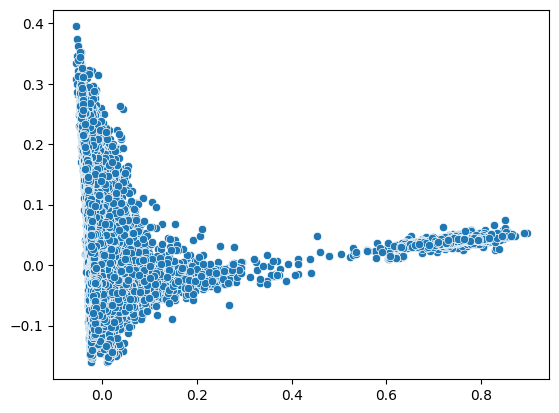

In [82]:
sns.scatterplot(x=X[:,0], y=X[:,1]);

não temos grupos bem definidos. Faz sentido não estar dando certo ate agora.

Tallvez uma tentativa usando o body

In [8]:
vectorizer = TfidfVectorizer(stop_words=pt_stopwords, max_features=1000)
X = vectorizer.fit_transform(df_itens_train['body'])

In [107]:
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X)

In [108]:
kmeans = KMeans(n_clusters=500, random_state=42)
pred = kmeans.fit_predict(X_pca)
silhouette_score(X_pca, pred)

np.float64(0.06582745426411792)

In [109]:
pca = PCA(n_components=25)
X_pca = pca.fit_transform(X)

In [110]:
kmeans = KMeans(n_clusters=250, random_state=42)
pred = kmeans.fit_predict(X_pca)
silhouette_score(X_pca, pred)

np.float64(0.09465527375433468)

In [111]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

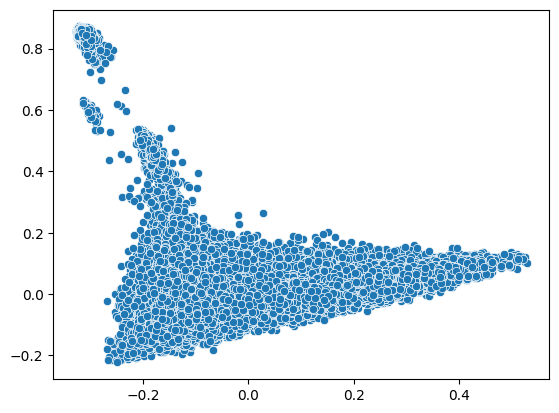

In [112]:
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1]);

In [6]:
from sklearn.cluster import DBSCAN

In [9]:
vectorizer = TfidfVectorizer(stop_words=pt_stopwords, max_features=1000, ngram_range=(1, 2))
X = vectorizer.fit_transform(titulo_e_caption)
X.shape

(230043, 1000)

In [12]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
pred = dbscan.fit_predict(X)
silhouette_score(X, pred)

np.float64(-0.2608786486022192)

In [13]:
pca = PCA(n_components=250)
X_pca = pca.fit_transform(X)

In [14]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
pred = dbscan.fit_predict(X_pca)
silhouette_score(X_pca, pred)

np.float64(-0.12481318215949104)

In [15]:
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X)

In [20]:
try:
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    pred = dbscan.fit_predict(X_pca)
    silhouette_score(X_pca, pred)
except MemoryError:
    print('Sem memoria suficiente....')

Sem memoria suficiente....


In [10]:
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X)

In [11]:
try:
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    pred = dbscan.fit_predict(X_pca)
    silhouette_score(X_pca, pred)
except MemoryError:
    print('Sem memoria suficiente....')

: 

DBSCAN também não deu muito certo. Esse algoritmo está consumindo muita memória. Aparentemente a clusterização não está se mostando uma opção viável no momento. Vou analisar melhor outros dados.

A clusterização não tem se mostrado uma opção viável para busca de textos similares.

#### Testando o calculo de similaridade a partir da função cosine_similarity

Encontrei outra função para calcular a distancia entre 2 textos, vou testar essa nova função.

In [6]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
vectorizer = TfidfVectorizer(stop_words=pt_stopwords, max_features=5000)
X = vectorizer.fit_transform(titulo_e_caption)

In [9]:
try:
    similaridades = cosine_similarity(X)
except MemoryError as e:
    print('Sem memoria suficiente....')
    print(e)

Sem memoria suficiente....
Unable to allocate 391. GiB for an array with shape (52485569509,) and data type int64


In [32]:
from sklearn.utils.extmath import safe_sparse_dot
from tqdm import tqdm

def compute_similarity(tfidf_matrix, top_n=5):
    similarities = []
    for i in tqdm(range(tfidf_matrix.shape[0])):
        row_vector = tfidf_matrix[i]
        sim_scores = safe_sparse_dot(row_vector, tfidf_matrix.T, dense_output=True)
        top_indices = sim_scores.argsort()[-top_n:][::-1]
        similarities.append((i, top_indices))
    return similarities

In [20]:
try:
    similaridades = compute_similarity(X, top_n=10)
except MemoryError as e:
    print('Sem memoria suficiente....')
    print(e)

  0%|          | 0/230043 [00:00<?, ?it/s]

  3%|▎         | 6744/230043 [59:33<32:52:13,  1.89it/s]    


Sem memoria suficiente....
Unable to allocate 75.0 MiB for an array with shape (19661707,) and data type int32


A quantidade de itens é muito grande, mas talvez a gente não tenha que se preocupar com as matérias mais antigas em um primeiro momento....

In [8]:
# 2 semanas antes do ultimo item
filtro_data = pd.to_datetime(df_itens_test['issued'].max()) - pd.Timedelta(days=14)
filtro_data

Timestamp('2022-08-01 02:57:16+0000', tz='UTC')

In [20]:
vectorizer = TfidfVectorizer(stop_words=pt_stopwords, max_features=250, ngram_range=(1, 2), min_df=0.2, max_df=0.8)
vectorizer.fit(df_itens_train['body'])

TfidfVectorizer(max_df=0.8, max_features=250, min_df=0.2, ngram_range=(1, 2),
                stop_words=['a', 'à', 'ao', 'aos', 'aquela', 'aquelas',
                            'aquele', 'aqueles', 'aquilo', 'as', 'às', 'até',
                            'com', 'como', 'da', 'das', 'de', 'dela', 'delas',
                            'dele', 'deles', 'depois', 'do', 'dos', 'e', 'é',
                            'ela', 'elas', 'ele', 'eles', ...])

In [21]:
', '.join(vectorizer.get_feature_names_out())

'10, acordo, ainda, além, ano, anos, antes, após, brasil, casa, caso, cidade, civil, conta, contra, desde, desta, dia, dias, disse, divulgação, diz, dois, duas, durante, estado, fazer, federal, feira, g1, grande, informou, local, maior, meio, mil, momento, nesta, notícias, onde, outras, outros, parte, paulo, pessoas, pode, polícia, porque, público, região, reprodução, rio, saúde, segunda, segundo, sendo, sexta, sobre, ter, todo, todos, três, tv, vai, veja, veja notícias, vídeos'

In [22]:
itens_filtrado = df_itens_test[pd.to_datetime(df_itens_test['issued']) >= filtro_data]
X = vectorizer.transform(itens_filtrado['body'])


In [36]:
try:
    similaridades = compute_similarity(X)
except MemoryError as e:
    print('Sem memoria suficiente....')
    print(e)

100%|██████████| 1081/1081 [00:00<00:00, 1350.28it/s]


In [37]:
similaridades[:3]

[(0, array([[595, 117, 325, ..., 249, 556,   0]], shape=(1, 1081))),
 (1, array([[1065,  117,  595, ...,  620,  431,    1]], shape=(1, 1081))),
 (2, array([[1050, 1065,  414, ...,  567,  548,    2]], shape=(1, 1081)))]

In [38]:
def print_similaridades(similaridades, itens_filtrado):
    for i in range(3):
        for j in range(1, 5):
            print(itens_filtrado.iloc[similaridades[i][1][0][-j]]['title'], ' -- ', itens_filtrado.iloc[similaridades[1][1][0][i]]['caption'])
            print('-----------------------------------')
        
        print('\n\n')

print_similaridades(similaridades, itens_filtrado)

Maceió começa a vacinar contra Covid crianças de 4 anos sem comorbidades  --  Interessados devem se inscrever  na secretaria da escola até o dia 15 de agosto.
-----------------------------------
Campanhas de vacinação contra pólio e multivacinação começam na segunda-feira em Alagoas   --  Interessados devem se inscrever  na secretaria da escola até o dia 15 de agosto.
-----------------------------------
Mogi das Cruzes abre novos agendamentos para vacinação contra Covid-19, nesta quarta-feira  --  Interessados devem se inscrever  na secretaria da escola até o dia 15 de agosto.
-----------------------------------
Cuiabá irá retomar vacinação da BCG em crianças; veja locais   --  Interessados devem se inscrever  na secretaria da escola até o dia 15 de agosto.
-----------------------------------



Adolescente filha de vítima de feminicídio é morta a tiros no ES e ex-namorado é preso suspeito do crime   --  No total foram analisados 66 itens, entre frutas, verduras, legumes e temperos. 
-

A combinação entre `TfidfVectorizer` para extração de tokens e o calculo de similaridades feito pela função `compute_similarity` está retornando resultados interessantes.

Acredito que o resultado atual pode ser aproveitado para a implementação do sistema de recomendação de noticias desse datathon.

### Criando a matriz de similaridades entre os textos

Primeiramente precisamos do modelo de vetorização que vamos usar para o sistema de recomendações

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords

import pandas as pd

import pickle
import nltk
import os

In [126]:
def obter_stopwords(linguagem:str):
    nltk.download('stopwords', quiet=True)
    return list(stopwords.words(linguagem))

def treinar_vectorizer(textos:pd.Series, linguagem='portuguese', max_features=5000, ngram_range=(1, 2), min_df=0.2, max_df=0.8):
    stopwords = obter_stopwords(linguagem)
    vectorizer = TfidfVectorizer(
        stop_words=stopwords, 
        max_features=max_features, 
        ngram_range=ngram_range, 
        min_df=min_df, 
        max_df=max_df
    )
    vectorizer.fit(textos)
    return vectorizer

def treinar_e_salvar_vectorizer(textos: pd.Series):
    os.makedirs('models', exist_ok=True)

    vectorizer = treinar_vectorizer(textos)

    with open(r'models/vectorizer_body.pkl', 'wb') as file:
        pickle.dump(vectorizer, file)
    
    return vectorizer

def carregar_vectorizer():
    with open(r'models/vectorizer_body.pkl', 'rb') as file:
        return pickle.load(file)
    
def carregar_ou_treinar_vectorizer(forcar_treino=False):
    if not forcar_treino and os.path.exists(r'models/vectorizer_body.pkl'):
        return carregar_vectorizer()
    else:
        textos = carregar_textos_recentes()
        return treinar_e_salvar_vectorizer(textos=textos['body'])
    
def carregar_textos_recentes(dias=14):
    df = pd.read_csv(r'data/itens/itens/long_format.csv')
    filtro_data = pd.to_datetime(df['issued'].max()) - pd.Timedelta(days=dias)
    return df[pd.to_datetime(df['issued']) >= filtro_data]

In [8]:
vectorizer = carregar_ou_treinar_vectorizer()

In [23]:
def obter_similaridades(textos:pd.Series, vectorizer:TfidfVectorizer, n_top=5):
    X = vectorizer.transform(textos)
    similaridades = cosine_similarity(X)
    return [ (it[-1], list(reversed(it[-n_top-1:-1]))) for it in similaridades.argsort() ]

In [24]:
materias = carregar_textos_recentes()
similaridades = obter_similaridades(materias['body'], vectorizer)

In [25]:
similaridades[0]

(np.int64(0),
 [np.int64(1260),
  np.int64(4870),
  np.int64(9849),
  np.int64(3138),
  np.int64(887)])

In [26]:
def print_similaridades(similaridades, textos):
    for base, sugestoes in similaridades:
        print(textos.iloc[base]['title'])
        for sugestao in sugestoes:
            print('--------------------------------------')
            print('  ', textos.iloc[sugestao]['title'])
        print('\n\n')

In [27]:
print_similaridades(similaridades[:3], materias)

Saúde descarta varíola dos macacos em dois imigrantes que passaram por exames no AC 
--------------------------------------
   Criança de 6 anos dá entrada em UPA de Rio Branco com suspeita de varíola dos macacos
--------------------------------------
   Jundiaí registra mais dois casos de varíola dos macacos
--------------------------------------
   Estado confirma primeiro caso de varíola dos macacos em Jarinu
--------------------------------------
   Sandy propaga levezas com Agnes Nunes e Wanessa Camargo no primeiro single do EP 'Nós, Voz, Eles 2'
--------------------------------------
   Acre investiga cinco casos suspeitos de varíola dos macacos e tem uma confirmação da doença 



Sine Acre oferece 37 vagas de emprego nesta terça-feira (2) ; confira a lista
--------------------------------------
   Sine Acre oferece 47 vagas de emprego nesta quinta-feira (4); confira a lista
--------------------------------------
   Sine Acre oferece 45 vagas de emprego nesta quarta-feira (3); co

A qualidade das sugestões está bem legal e aproveitavel. Podemos seguir em frente com as sugestões obtidas a partir desse código.

Vou salvar o resultado desse código para utilizações posteriores.

In [34]:
def converter_em_ids_das_materias(sugestoes, materias):
    resultado = []
    for base, similares in sugestoes:
        linha = [
            materias.iloc[base]['page'],
            *[ materias.iloc[i]['page'] for i in similares ]
        ]
        resultado.append(linha)
    return pd.DataFrame(resultado, columns=['base', 'sugestao1', 'sugestao2', 'sugestao3', 'sugestao4', 'sugestao5'])

In [37]:
df_sugestoes = converter_em_ids_das_materias(similaridades, materias)
df_sugestoes.head(3)

,base,sugestao1,sugestao2,sugestao3,sugestao4,sugestao5
0,790f8f6d-2674-462d-ab94-47239c2f60d5,531a8b77-e546-400a-ab9e-f05c5b8c2dfc,5e7b1c29-49c1-43a3-bf17-01f18e63a6c3,5b381dbc-b364-48e4-861c-816cb043b30f,552b9004-5ac4-44c2-8edb-84232e3bfe4c,6cd71ce6-9d26-480c-b6f8-e7268e1dc8c2
1,edc93569-bf37-437d-a6c3-fda029f8bc70,5a301c99-f2cd-4af7-9dca-3a5497651191,9eddd003-a771-499a-ae3c-d3874d12a379,4eda2c3c-5947-4ff4-a514-03cc8472bb5c,6af5a619-d862-4b05-8c99-e7a4ba66754c,047d0f21-8f2b-4c14-89e8-0efb2662287e
2,d458eb60-018c-42d1-9731-7d65be3ada78,3395c0ad-e244-4592-8a17-87fe469b05d1,2ffb7eca-ae76-4f39-9957-ec25418ebaf6,5bc2e357-a3c5-41a3-9ea1-bbb2b54a056c,ceb7c1ae-f0da-422b-a697-caa3a71d4dd0,6d518d03-adbe-4cad-a7b6-28ec8d88adba


In [38]:
df_sugestoes.to_csv(r'data/sugestoes.csv', index=False)

Agora eu tenho um dataframe com as recomendações de materias similares para utilização em analises futuras!

### Análise do dataframe de atividade dos usuários

In [7]:
df_treino_train.head(1)

,userId,userType,historySize,history,timestampHistory,numberOfClicksHistory,timeOnPageHistory,scrollPercentageHistory,pageVisitsCountHistory
2706609,3af3dd1335a8bcd0a92d7ede0b077a28ec6edb2953494f...,Logged,376,5ad189e3-77e6-4c5e-9eed-8979ba58e283,2022-08-10 23:36:45.519,21,54004,35.24,2


#### userType

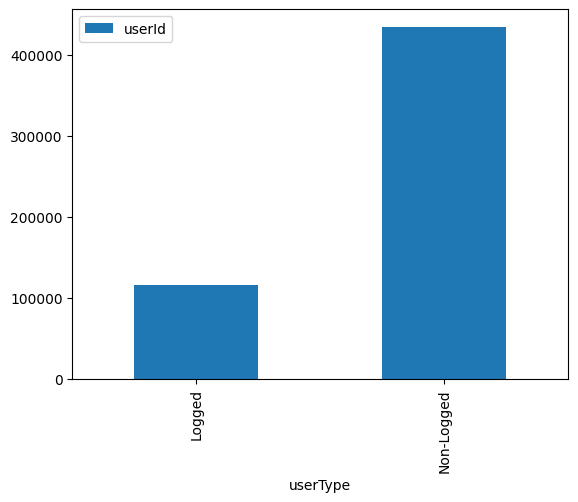

In [14]:
df_treino_train[['userId', 'userType']].drop_duplicates().groupby('userType').count().plot(kind='bar');

O dataset esta muito desbalanceado, mas é esperado que tenha mais usuários deslogados que usuários logados.

#### historySize

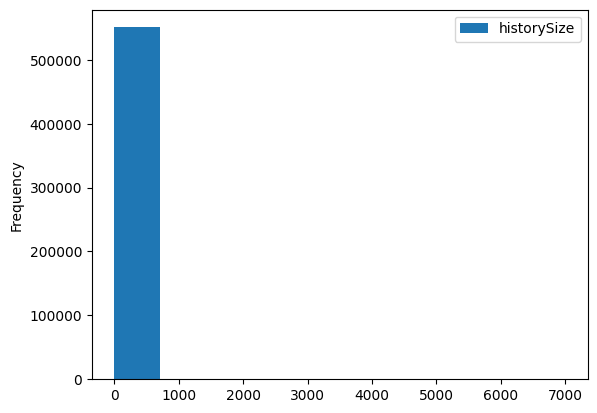

In [51]:
df_treino_train[['userId', 'userType', 'historySize']].drop_duplicates().drop('userId', axis=1).plot(kind='hist');

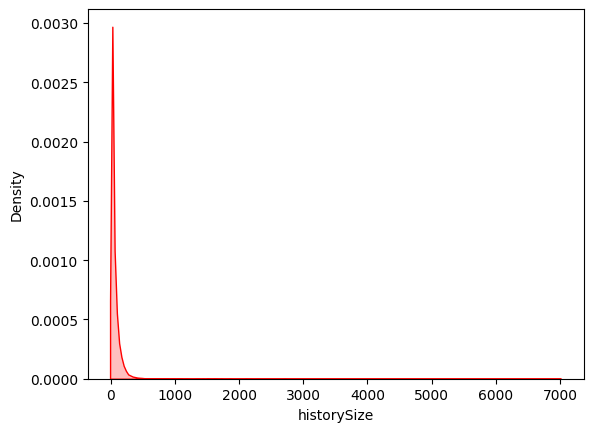

In [68]:
sns.kdeplot(df_treino_train[['userId', 'userType', 'historySize']].drop_duplicates()['historySize'], fill=True, color='red');

Usando o KDE, podemos ver que tem uma grande concentração de usuarios que lêem menos que 1000 matérias, mas uma quantidade quase constante de usuários que leram mais de 1000.

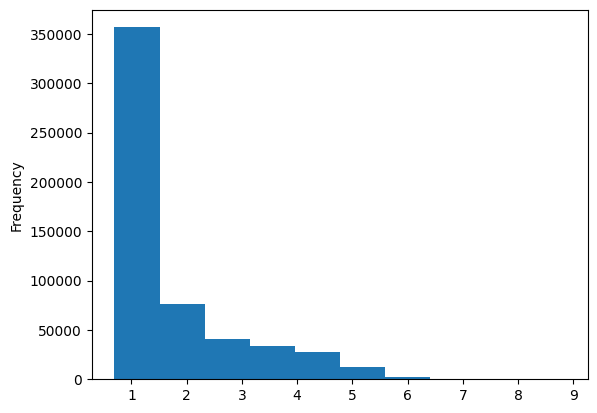

In [73]:
np.log1p(df_treino_train[['userId', 'userType', 'historySize']].drop_duplicates()['historySize']).plot(kind='hist');

Usando uma escala logaritmica, podemos reduzir a distorção do gráfico e ter uma noção melhor da distribuição dos dados. Essa informação pode ajudar a traçar um perfil dos usuários, ajudando a separar usuários frequentes dos usuários ocasionais. 

In [49]:
len(df_treino_train), len(df_treino_train[df_treino_train['historySize'] < 20])

(7311556, 1319078)

Por mais que a distribuição de usuários que leram mais de 20 matérias seja mais distribuida a maior parte dos usuários ficam acima dessa faixa de acessos. Essa distribuição está dificulando a analise da distribuição dos dados.

#### scrollPercentageHistory

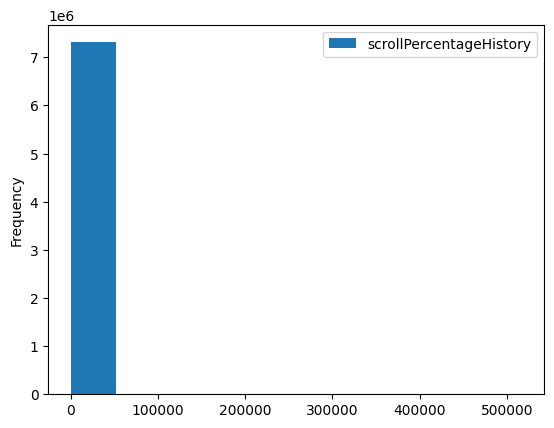

In [79]:
df_treino_train[['scrollPercentageHistory']].plot(kind='hist');

In [80]:
print(len(df_treino_train), len(df_treino_train[df_treino_train['scrollPercentageHistory'] > 100.0]))

7311556 1993


é muito estranho que exista casos em que a porcentagem de scroll seja maior que 100%. Acredito que esses casos podem estar relacionados a bugs na ferramenta que captura essas métricas.

In [9]:
df_treino_train.loc[df_treino_train['scrollPercentageHistory'] > 100.0, 'scrollPercentageHistory'] = 100.0

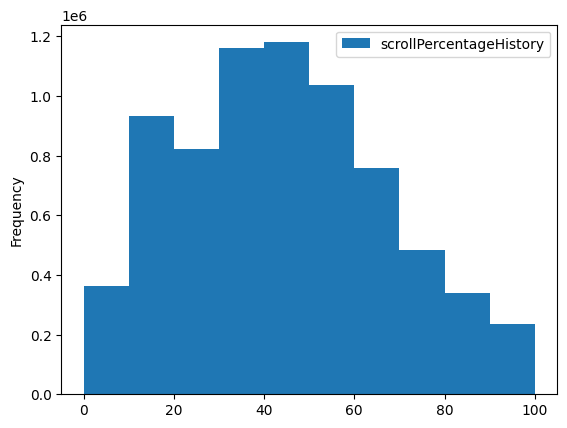

In [82]:
df_treino_train[['scrollPercentageHistory']].plot(kind='hist');

#### timeOnPageHistory

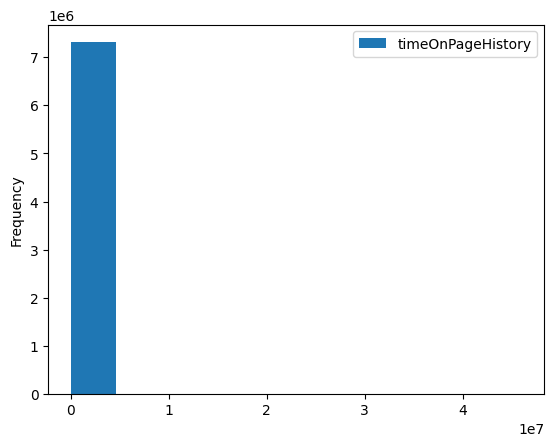

In [83]:
df_treino_train[['timeOnPageHistory']].plot(kind='hist');

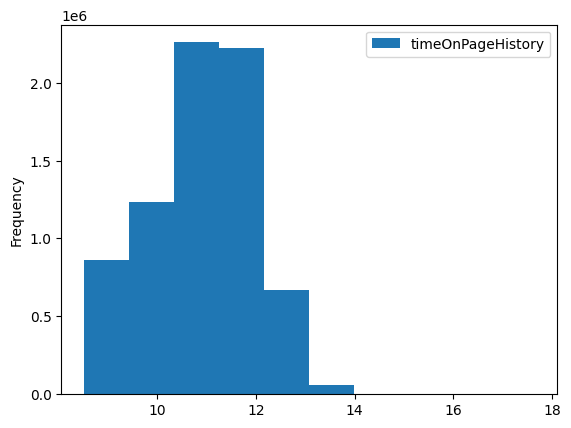

In [84]:
np.log1p(df_treino_train[['timeOnPageHistory']]).plot(kind='hist');

#### pageVisitsCountHistory

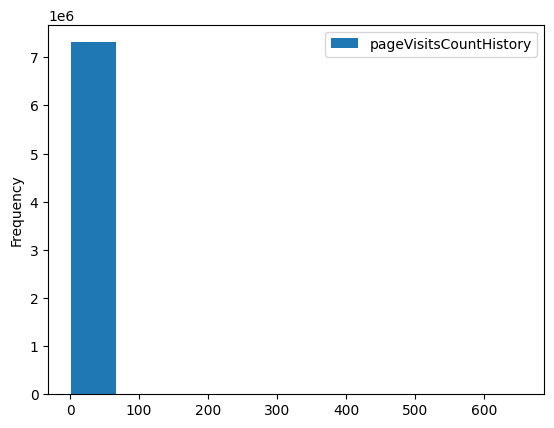

In [85]:
df_treino_train[['pageVisitsCountHistory']].plot(kind='hist');

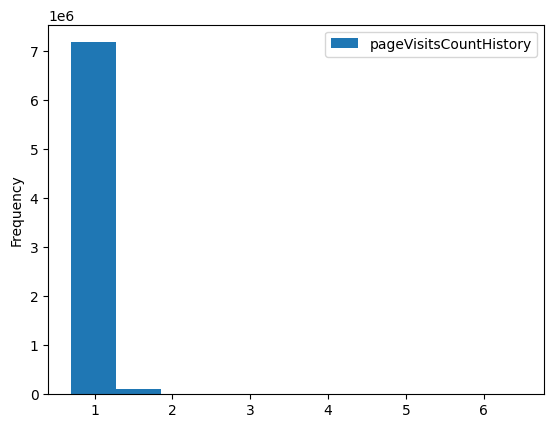

In [86]:
np.log1p(df_treino_train[['pageVisitsCountHistory']]).plot(kind='hist');

#### history

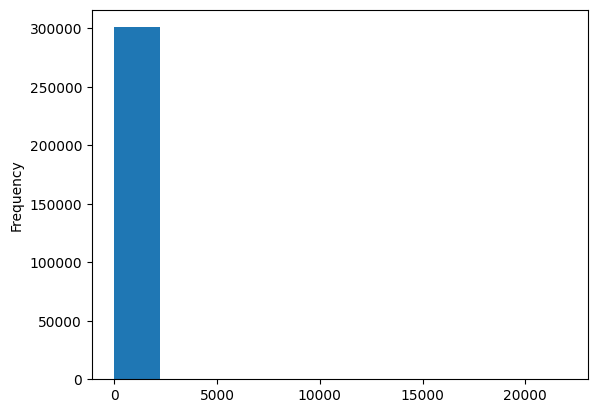

In [90]:
df_treino_train['history'].value_counts().plot(kind='hist');

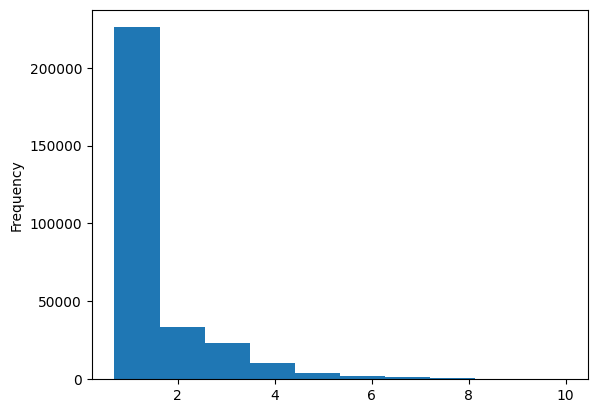

In [91]:
np.log1p(df_treino_train['history'].value_counts()).plot(kind='hist');

In [92]:
df_treino_train['history'].value_counts().sort_values(ascending=False).head(10)

history
d2593c3d-2347-40d9-948c-b6065e8459a9    21950
f6b5d170-48b9-4f8e-88d4-c84b6668f3bd    19613
1f32787b-de2b-49be-8c20-ddaeae34cc22    16534
f0a78e58-ec7e-494c-9462-fbd6446a9a89    16119
6a83890a-d9e9-4f6b-a6c6-90d031785bbf    15966
855d20b7-53f2-4678-a10f-55402d085018    15328
4c63d7cd-4902-4ffb-9b94-578b1b2151f0    15075
1c27cf97-b20c-4e40-b1f1-288b721517b3    14609
bf257382-74fb-4392-ad6a-143240e39f81    13344
a36c98b5-f159-48f8-9f5a-1fc6ea9956c8    13288
Name: count, dtype: int64

In [93]:
df_treino_train['history'].value_counts().sort_values().head(10)

history
 486ba81a-8f76-49d3-836e-bca5e109272e    1
 d1672ec7-3c13-4571-a993-bb22691a192e    1
 802da87e-676b-421e-9d41-2fcbb5ce4b28    1
 3fc1cd94-b290-4456-b600-dbf8f5fac88e    1
 31865ff6-594b-4ae1-bc6e-6339fbf44f6e    1
efd324d1-9e31-4653-9da6-4cfe86f26993     1
 e0b7ff1c-54ed-4345-8292-9f6918eb48b5    1
4bd197cd-0d04-42a4-94eb-aad091d7bfc9     1
49435b8a-f34e-471b-9c28-14e21413c148     1
0c02336c-cbff-4aaf-aa1b-3017c56e0a47     1
Name: count, dtype: int64

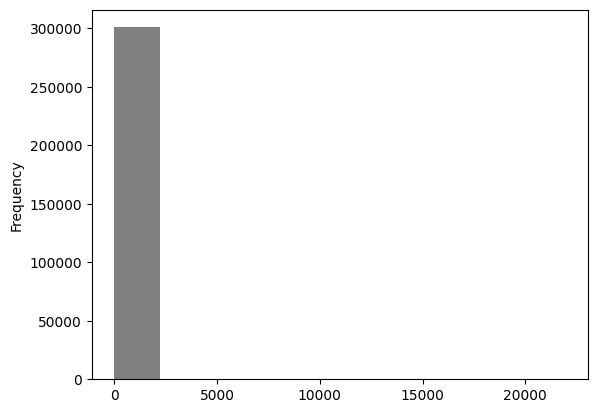

In [11]:
df_treino_train.groupby('history').count().plot(kind='hist', legend=False);

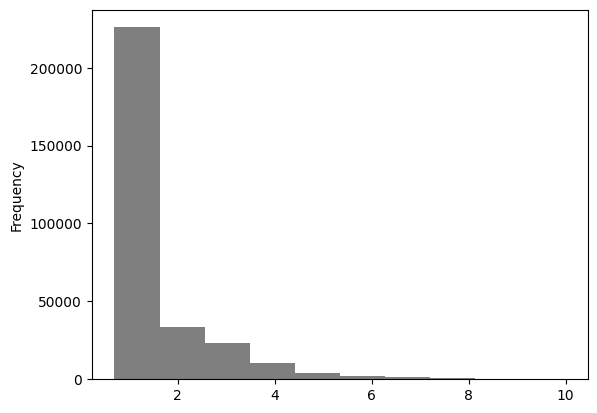

In [12]:
np.log1p(df_treino_train.groupby('history').count()).plot(kind='hist', legend=False);

In [17]:
np.log1p(df_treino_train.groupby('history').count())['userId'].sort_values(ascending=False).head(10)

history
d2593c3d-2347-40d9-948c-b6065e8459a9    9.996568
f6b5d170-48b9-4f8e-88d4-c84b6668f3bd    9.883999
1f32787b-de2b-49be-8c20-ddaeae34cc22    9.713235
f0a78e58-ec7e-494c-9462-fbd6446a9a89    9.687816
6a83890a-d9e9-4f6b-a6c6-90d031785bbf    9.678279
855d20b7-53f2-4678-a10f-55402d085018    9.637502
4c63d7cd-4902-4ffb-9b94-578b1b2151f0    9.620859
1c27cf97-b20c-4e40-b1f1-288b721517b3    9.589462
bf257382-74fb-4392-ad6a-143240e39f81    9.498897
a36c98b5-f159-48f8-9f5a-1fc6ea9956c8    9.494692
Name: userId, dtype: float64

In [18]:
df_treino_train.groupby('history').count()['userId'].sort_values(ascending=False).head(10)

history
d2593c3d-2347-40d9-948c-b6065e8459a9    21950
f6b5d170-48b9-4f8e-88d4-c84b6668f3bd    19613
1f32787b-de2b-49be-8c20-ddaeae34cc22    16534
f0a78e58-ec7e-494c-9462-fbd6446a9a89    16119
6a83890a-d9e9-4f6b-a6c6-90d031785bbf    15966
855d20b7-53f2-4678-a10f-55402d085018    15328
4c63d7cd-4902-4ffb-9b94-578b1b2151f0    15075
1c27cf97-b20c-4e40-b1f1-288b721517b3    14609
bf257382-74fb-4392-ad6a-143240e39f81    13344
a36c98b5-f159-48f8-9f5a-1fc6ea9956c8    13288
Name: userId, dtype: int64

In [20]:
df_treino_train.groupby('history').count()['userId'].median()

np.float64(1.0)

In [25]:
df_treino_train.groupby('history').count()['userId'].quantile([0.25, 0.50, 0.75, 0.80, 0.90, 0.95, 0.99])

0.25      1.0
0.50      1.0
0.75      5.0
0.80      7.0
0.90     18.0
0.95     40.0
0.99    369.0
Name: userId, dtype: float64

O resultado desses percentiles, fica bem claro que a maior parte das notícias não são muito acessadas. Existe ainda a possibilidade de que existam textos que nunca foram acessados por nenhum usuário.

#### Tempo médio de acesso de uma matéria

In [10]:
acessos = df_treino_train[['history', 'dateTimeHistory']]
acessos.head(2)

,history,dateTimeHistory
2706609,5ad189e3-77e6-4c5e-9eed-8979ba58e283,2022-08-10 23:36:45.519
3938466,5b82930f-fdd7-4e5e-b720-8b1b8eb709d8,2022-08-04 11:22:47.461


In [11]:
acessos = acessos.set_index('history').join(df_itens.set_index('page')[['issued']], how='inner')

In [12]:
acessos['diff_minutos'] = (acessos['dateTimeHistory'] - acessos['issued']).dt.total_seconds() / 60
acessos['diff_horas'] = acessos['diff_minutos'] / 60
acessos['diff_dias'] = acessos['diff_horas'] / 24

acessos.head()

,dateTimeHistory,issued,diff_minutos,diff_horas,diff_dias
history,,,,,
de813d52-b34c-4480-96b3-84a35fd80b57,2022-08-01 10:17:56.420,2019-06-17 08:57:10,1.643121e+06,27385.346228,1141.056093
ba947c74-2d9f-4d98-b56a-47c910be4412,2022-07-17 17:47:11.318,2022-01-07 19:40:34,2.749266e+05,4582.110366,190.921265
1711978b-b9d2-409f-acb9-3863f29e0c0d,2022-07-14 15:40:56.646,2022-03-22 12:00:45,1.643802e+05,2739.669902,114.152913
cad45955-4c7a-4a9f-88e8-379906ca65d9,2022-07-06 17:26:06.752,2020-08-05 18:49:15,1.007917e+06,16798.614376,699.942266
f2967a51-efd4-4350-8448-cceeffffacfa,2022-08-01 16:35:15.634,2022-03-17 20:51:57,1.970233e+05,3283.721843,136.821743


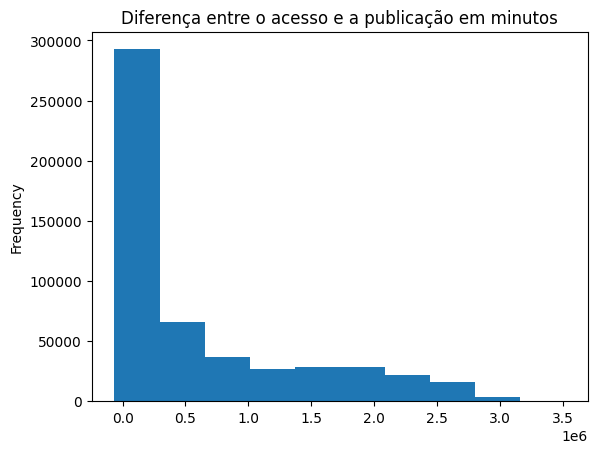

In [11]:
acessos['diff_minutos'].plot(kind='hist', title='Diferença entre o acesso e a publicação em minutos');

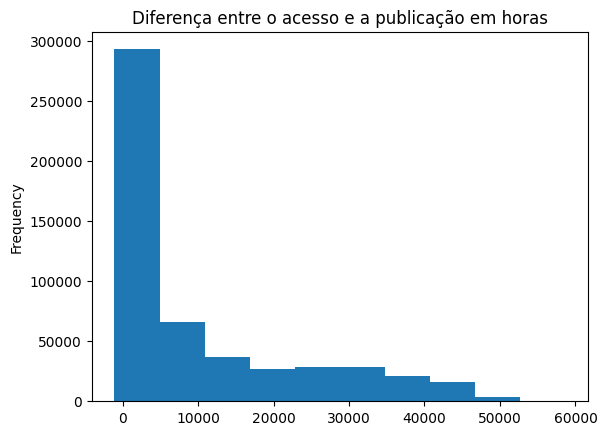

In [12]:
acessos['diff_horas'].plot(kind='hist', title='Diferença entre o acesso e a publicação em horas');

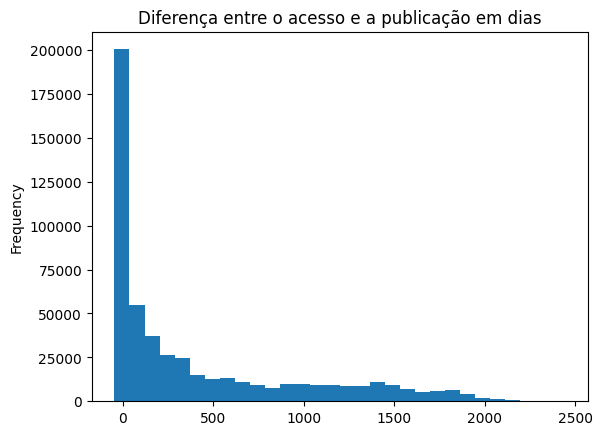

In [13]:
acessos['diff_dias'].plot(kind='hist', title='Diferença entre o acesso e a publicação em dias', bins=30);

Mesmo após muito tempo da matéria lançada ainda temos novos acessos. Isso é um problema, já que no momento o calculo de semelhança entre as matérias está considerando apenas as 2 ultimas semanas. Ainda preciso de uma forma de calcular e atualizar a lista de semelhanças para todas as matérias de uma forma otimizada.

Podemos considerar que uma matéria pode se manter relevante por pelo menos 500 dias após sua publicação.

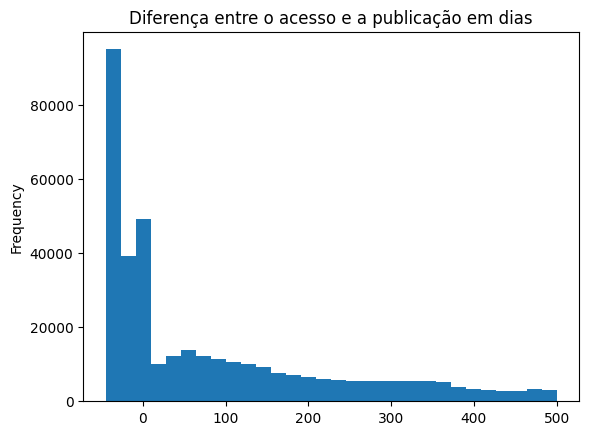

In [14]:
acessos.loc[acessos['diff_dias'] < 500, 'diff_dias'].plot(kind='hist', title='Diferença entre o acesso e a publicação em dias', bins=30);

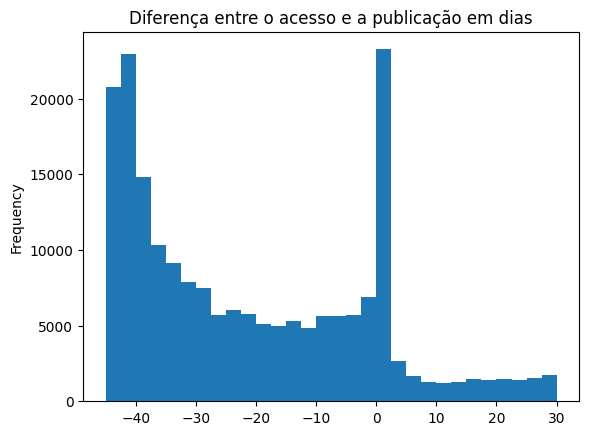

In [15]:
acessos.loc[acessos['diff_dias'] < 30, 'diff_dias'].plot(kind='hist', title='Diferença entre o acesso e a publicação em dias', bins=30);

In [16]:
acessos[acessos['diff_dias'] < 0].head()

,dateTimeHistory,issued,diff_minutos,diff_horas,diff_dias
history,,,,,
5a8cd496-c577-489f-b8e5-58ffe739d191,2022-07-31 14:29:12.576,2022-08-01 10:20:07,-1190.907067,-19.848451,-0.827019
27112b95-15dc-4363-9d7a-0baf0d23b206,2022-07-02 06:15:20.216,2022-08-14 20:22:51,-62767.513067,-1046.125218,-43.588551
3c787cdc-99f7-4001-94ac-4edb2e971b94,2022-07-11 15:48:04.838,2022-08-13 21:22:51,-47854.769367,-797.579489,-33.232479
10f33dfb-319d-4763-aad8-15ec6bcf1a3f,2022-07-15 17:35:55.477,2022-08-12 12:31:53,-40015.958717,-666.932645,-27.788860
abf9b042-1205-465b-b24f-e3cc3907db83,2022-07-13 18:05:12.685,2022-08-12 11:56:26,-42831.221917,-713.853699,-29.743904


Como podem ter matérias com acesso anterior à sua publicação?

Muito provavelmente nesse caso, ou a data de publicação ou de acesso está incorreta. Talvez uma solução interessante seja definir a data de publicação como a primeira data de acesso à matéria.

In [16]:
# Agrupar por 'history' e obter a menor data de acesso
min_access_dates = df_treino_train.groupby('history')['dateTimeHistory'].min()

# Atualizar a coluna 'issued' de df_itens
df_itens['issued'] = df_itens.apply(
    lambda row: min(row['issued'], min_access_dates.get(row['page'], row['issued'])),
    axis=1
)

In [17]:
acessos = df_treino_train[['history', 'dateTimeHistory']]
acessos = acessos.set_index('history').join(df_itens.set_index('page')[['issued']], how='inner')
acessos['diff_minutos'] = (acessos['dateTimeHistory'] - acessos['issued']).dt.total_seconds() / 60
acessos['diff_horas'] = acessos['diff_minutos'] / 60
acessos['diff_dias'] = acessos['diff_horas'] / 24

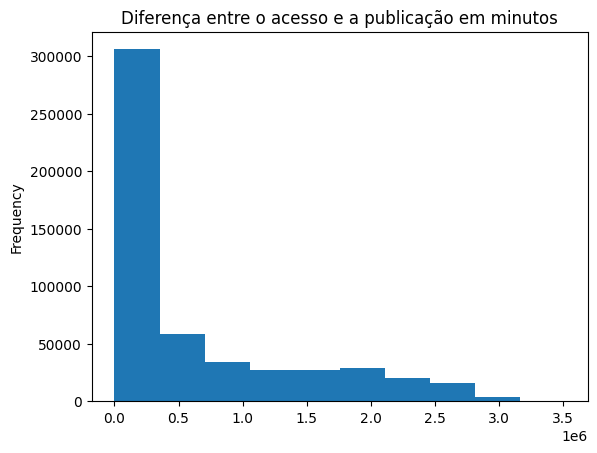

In [18]:
acessos['diff_minutos'].plot(kind='hist', title='Diferença entre o acesso e a publicação em minutos');

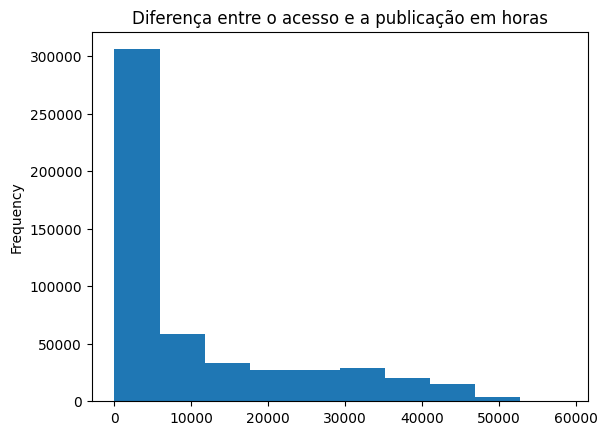

In [22]:
acessos['diff_horas'].plot(kind='hist', title='Diferença entre o acesso e a publicação em horas');

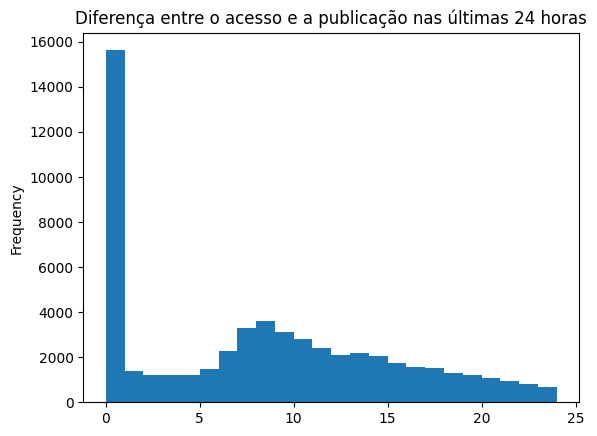

In [26]:
acessos.loc[acessos['diff_horas'] <= 24, 'diff_horas'].plot(kind='hist', title='Diferença entre o acesso e a publicação nas últimas 24 horas', bins=24);

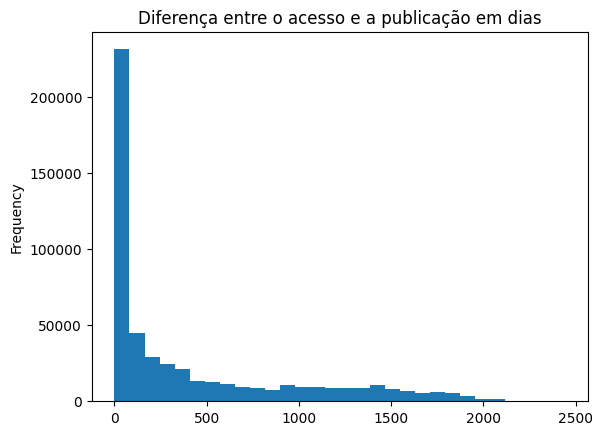

In [23]:
acessos['diff_dias'].plot(kind='hist', title='Diferença entre o acesso e a publicação em dias', bins=30);

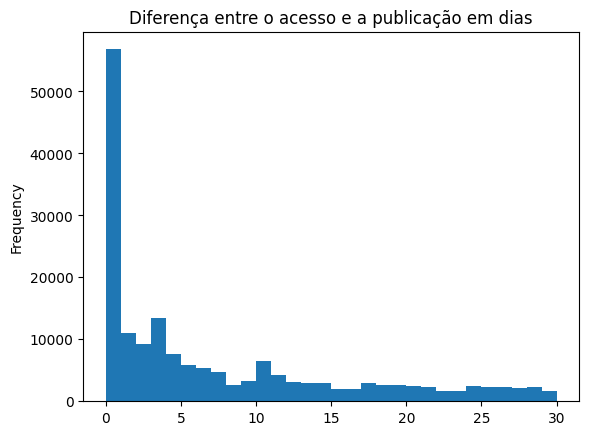

In [24]:
acessos.loc[acessos['diff_dias'] < 30, 'diff_dias'].plot(kind='hist', title='Diferença entre o acesso e a publicação em dias', bins=30);

Não houve mudanças significativas nos histogramas, mas pelo menos agora os dados parecem mais consistentes.

#### popularidade

Noticias populares são aquelas que possuem um grande interesse do público. É de se esperar que notícias que tenham uma grande quantidade de acessos nas primeiras horas sejam classificadas como populares.

Aqui eu pretendo entender mais sobre o que leva uma notícia a ter grande apelo popular.

In [13]:
acessos_primeira_hora = acessos[acessos['diff_horas'] <= 24]
acessos_primeira_hora['diff_horas_int'] = acessos_primeira_hora['diff_horas'].astype('int')
acessos_primeira_hora.head(1)

,dateTimeHistory,issued,diff_minutos,diff_horas,diff_dias,diff_horas_int
history,,,,,,
5a8cd496-c577-489f-b8e5-58ffe739d191,2022-07-31 14:29:12.576,2022-08-01 10:20:07,-1190.907067,-19.848451,-0.827019,-19


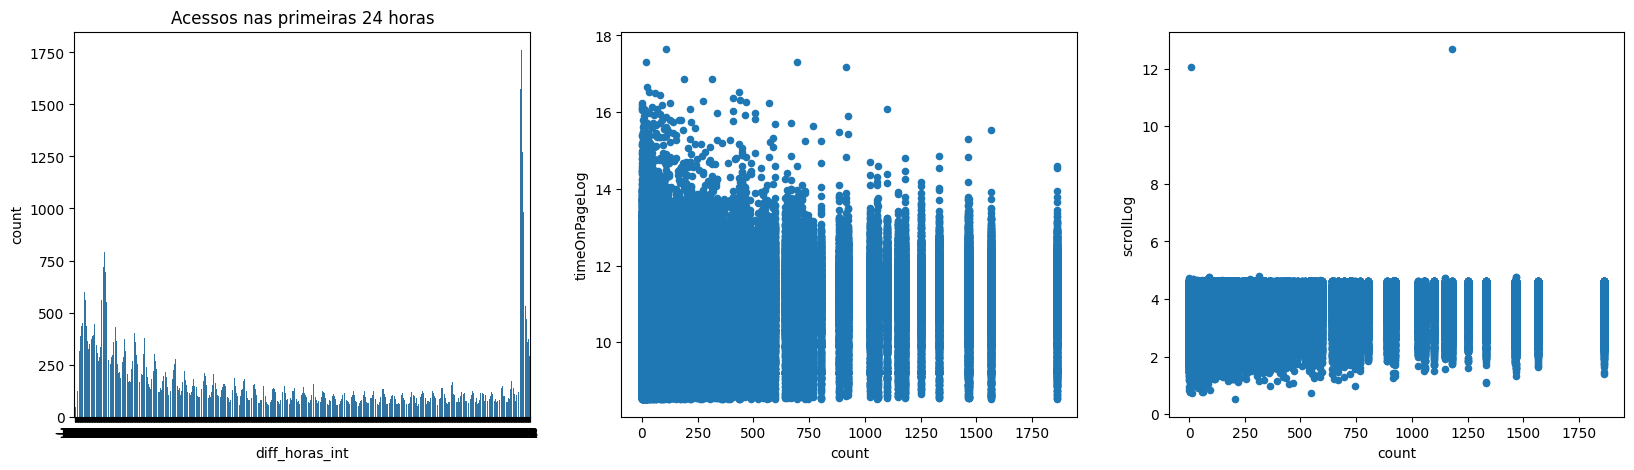

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes = axes.flatten()

# Contagem de acessos por hora
sns.countplot(data=acessos_primeira_hora, x='diff_horas_int', ax=axes[0]);
axes[0].set_title('Acessos nas primeiras 24 horas');

# Tempo até o acesso versus tempo na pagina
df_treino_train['timeOnPageLog'] = np.log1p(df_treino_train['timeOnPageHistory'])
df_treino_train[['history', 'timeOnPageLog']].set_index('history') \
        .join(acessos_primeira_hora.reset_index()['history'].value_counts(), how='inner') \
        .plot(kind='scatter', x='count', y='timeOnPageLog', ax=axes[1]);


# Tempo até o acesso versus porcentagem de scroll da pagina versus
df_treino_train['scrollLog'] = np.log1p(df_treino_train['scrollPercentageHistory'])
df_treino_train[['history', 'scrollLog']].set_index('history') \
        .join(acessos_primeira_hora.reset_index()['history'].value_counts(), how='inner') \
        .plot(kind='scatter', x='count', y='scrollLog', ax=axes[2]);


Ok... nem o tempo de pagina nem a porcentagem de scroll estão parecendo muito interessantes para identificar de uma notícia é popular ou não.

Por hora, vou considerar apenas a quantidade de acessos na primeira hora após a publicação da matéria.

In [226]:
df_treino.shape, df_treino[df_treino['history'].isin(df_itens['page'])].shape

((8123951, 10), (577942, 10))

In [227]:
df_itens.shape, df_itens[df_itens['page'].isin(df_treino['history'])].shape

((255603, 7), (78664, 7))

Percebi um problema que pode afetar minha estratégia negativamente. Existes dados de acessos referenciando matérias que não existem, e vice versa. Vou fazer um filtro para mitigar esse problema 

In [228]:
df_treino_match = df_treino[df_treino['history'].isin(df_itens['page'])]
df_itens_match = df_itens[df_itens['page'].isin(df_treino['history'])]

In [248]:
def obtem_materias_populares(df_treino: pd.DataFrame, df_itens:pd.DataFrame):
    # Corrige o campo issued de df_itens
    min_access_dates = df_treino.groupby('history')['dateTimeHistory'].min()
    df_itens['issued'] = df_itens.apply(
        lambda row: min(row['issued'], min_access_dates.get(row['page'], row['issued'])),
        axis=1
    )

    # filtra apenas os acessos nas primeira hora
    acessos = df_treino[['history', 'dateTimeHistory']]
    acessos = acessos.set_index('history').join(df_itens.set_index('page')[['issued']], how='inner')
    acessos['primeira_hora'] = ((acessos['dateTimeHistory'] - acessos['issued']).dt.total_seconds() / 3600) <= 1.0
    acessos = acessos[acessos['primeira_hora']].reset_index()

    # Contagem de acessos
    count_acessos = acessos['history'].value_counts()

    # 90 percentil
    min_acessos = count_acessos.quantile(0.9)

    # lista materias em que a quantidade de acessos na primeira hora é maior que min_acessos
    materias_populares = count_acessos[count_acessos > min_acessos].index

    return df_itens[df_itens['page'].isin(materias_populares)]


In [249]:
if os.path.exists(r'data/materias_populares.csv'):
    materias_populares = pd.read_csv(r'data/materias_populares.csv')
else:
    materias_populares = obtem_materias_populares(df_treino_match, df_itens_match)
    materias_populares.to_csv(r'data/materias_populares.csv', index=False)

#### Similaridades entre notícias populares

In [284]:
vectorizer = carregar_ou_treinar_vectorizer()
X = vectorizer.transform(materias_populares['body'])
similaridades = cosine_similarity(X)

In [306]:
# calular media de similaridades por linha
pd.Series(similaridades.mean(axis=1)).describe()

count    875.000000
mean       0.270221
std        0.059433
min        0.000000
25%        0.234886
50%        0.271659
75%        0.311891
max        0.431209
dtype: float64

In [310]:
recentes = df_itens_match[df_itens_match['issued'] >= df_itens_match['issued'].max() - pd.Timedelta(days=30)]
X_recentes = vectorizer.transform(recentes['body'])

In [311]:
X.shape, X_recentes.shape

((875, 45), (2531, 45))

In [312]:
similaridades_pop_rec = np.array(cosine_similarity(X_recentes, X))
similaridades_pop_rec.shape

(2531, 875)

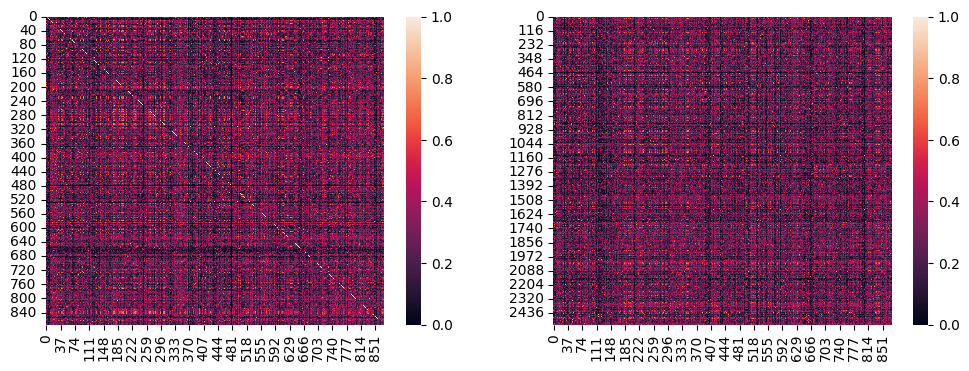

In [313]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes = axes.flatten()

sns.heatmap(similaridades, ax=axes[0]);
sns.heatmap(similaridades_pop_rec, ax=axes[1]);

In [274]:
similaridades_pop_rec.shape, recentes.shape

((543, 875), (543, 7))

In [314]:
print('Mean: ', np.mean(similaridades_pop_rec))
print('Max: ', similaridades_pop_rec.max())
print('Min: ', similaridades_pop_rec.min())
print('25 Perc:', np.percentile(similaridades_pop_rec, 25))
print('75 percentile:', np.percentile(similaridades_pop_rec, 75))
print('90 percentile:', np.percentile(similaridades_pop_rec, 90))
print('99 percentile:', np.percentile(similaridades_pop_rec, 99))

Mean:  0.253406197735288
Max:  1.0000000000000004
Min:  0.0
25 Perc: 0.14178465829223616
75 percentile: 0.34879443446487685
90 percentile: 0.45778673082208726
99 percentile: 0.6456618842956172


In [317]:
sorted(similaridades_pop_rec.max(axis=1), reverse=True)[:10]

[np.float64(1.0000000000000004),
 np.float64(1.0000000000000002),
 np.float64(1.0000000000000002),
 np.float64(1.0000000000000002),
 np.float64(1.0000000000000002),
 np.float64(1.0000000000000002),
 np.float64(1.0000000000000002),
 np.float64(1.0000000000000002),
 np.float64(1.0000000000000002),
 np.float64(1.0)]

In [277]:
list(recentes.iloc[similaridades_pop_rec[:,0].argsort()[-5:][::-1]]['title'])

['Inflação anual da Turquia atinge quase 80% em julho',
 "Ao anunciar apoio a Lula, Janones diz a eleitores que propostas serão mantidas pelo PT: 'Não poderia virar as costas para vocês'",
 "Demora por cirurgia no olho faz paciente temer perder a visão no Rio; 'Não consigo ler nada', diz idoso ",
 'Detritos encontrados na Austrália são da SpaceX, diz agência espacial',
 'Tensão em Taiwan: o longo histórico de Nancy Pelosi em oposição à China']

In [278]:
list(recentes.iloc[similaridades_pop_rec.mean(axis=1).argsort()[-5:][::-1]]['title'])

['Júri do caso da fisioterapeuta que se fingiu de morta após receber 68 facadas a mando do namorado em Salvador é adiado',
 "'Nossa presença não garante mais a segurança dos nossos filhos', diz tio de adolescente morta durante assalto em Salvador",
 'Acusado de matar ex-namorada a facadas em Zabelê, PB, vai a júri popular',
 'Marcado júri popular do caso da fisioterapeuta que se fingiu de morta   após receber 68 golpes de faca a mando do namorado na BA',
 'Danielly, Nataly e Lola: apenas um de três casos de violência envolvendo mulheres trans de Mogi resultou na prisão do suspeito']

In [279]:
list(recentes.iloc[similaridades_pop_rec.max(axis=1).argsort()[-5:][::-1]]['title'])

['Acidente entre caminhonete e ônibus mata uma pessoa e deixa mais de 20 feridas, em Campo Mourão',
 'Por que o Kansas, tradicionalmente republicano, rejeitou o fim do aborto',
 'VÍDEO: funcionário é agredido em frente de escola em Juiz de Fora',
 'Nunes Marques suspende efeitos de duas condenações de Arruda por improbidade administrativa',
 'Homem suspeito de matar ex-namorada em BH tem prisão preventiva decretada']

Quero comparar a quantidade de leitores das duas listas, para ver se consigo comparar o resultado das sugestões.

In [283]:
similaridades_pop_rec[0].argsort()[-10:]

array([370, 120, 569, 415, 767, 473, 106, 780, 257,   9])

In [291]:
lista_susgestao_simples = list(recentes.iloc[similaridades_pop_rec[:,0].argsort()[-10:]]['page'])
lista_susgestao_media = list(recentes.iloc[similaridades_pop_rec.mean(axis=1).argsort()[-10:]]['page'])
lista_susgestao_max = list(recentes.iloc[similaridades_pop_rec.max(axis=1).argsort()[-10:]]['page'])

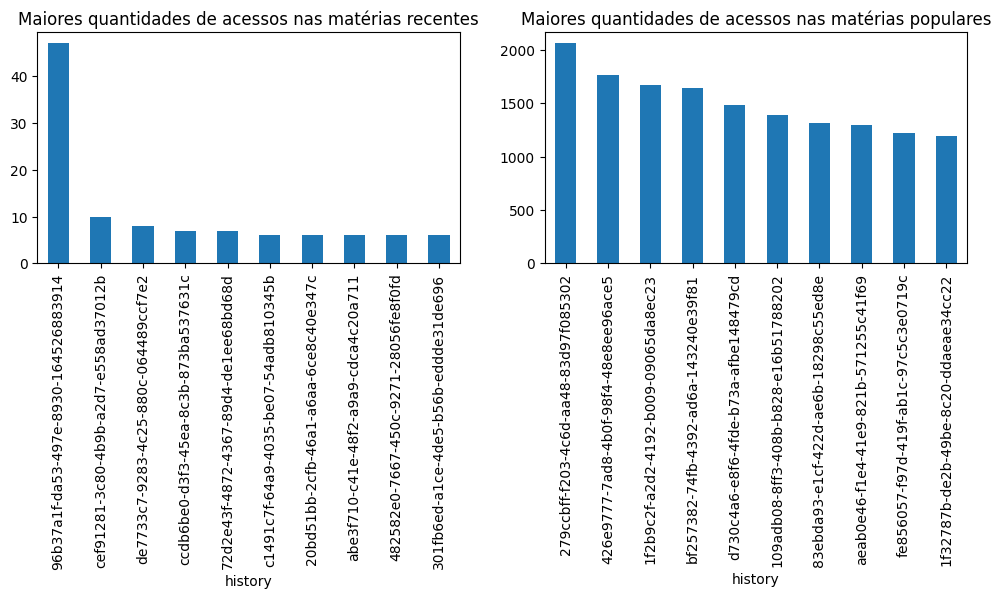

In [322]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
axes = axes.flatten()

df_treino[df_treino['history'].isin(recentes['page'])]['history'].value_counts().sort_values(ascending=False)[:10].plot(kind='bar', ax=axes[0])
axes[0].set_title('Maiores quantidades de acessos nas matérias recentes')

df_treino[df_treino['history'].isin(materias_populares['page'])]['history'].value_counts().sort_values(ascending=False)[:10].plot(kind='bar', ax=axes[1])
axes[1].set_title('Maiores quantidades de acessos nas matérias populares');

As matérias mais recentes, em geral não estão tendo uma grande quantidade de visualizações, se comparadas com as matérias mais populares, então também não podemos emperar que as matérias que vamos sugerir tenham uma quantidade muito expressiva de acessos.

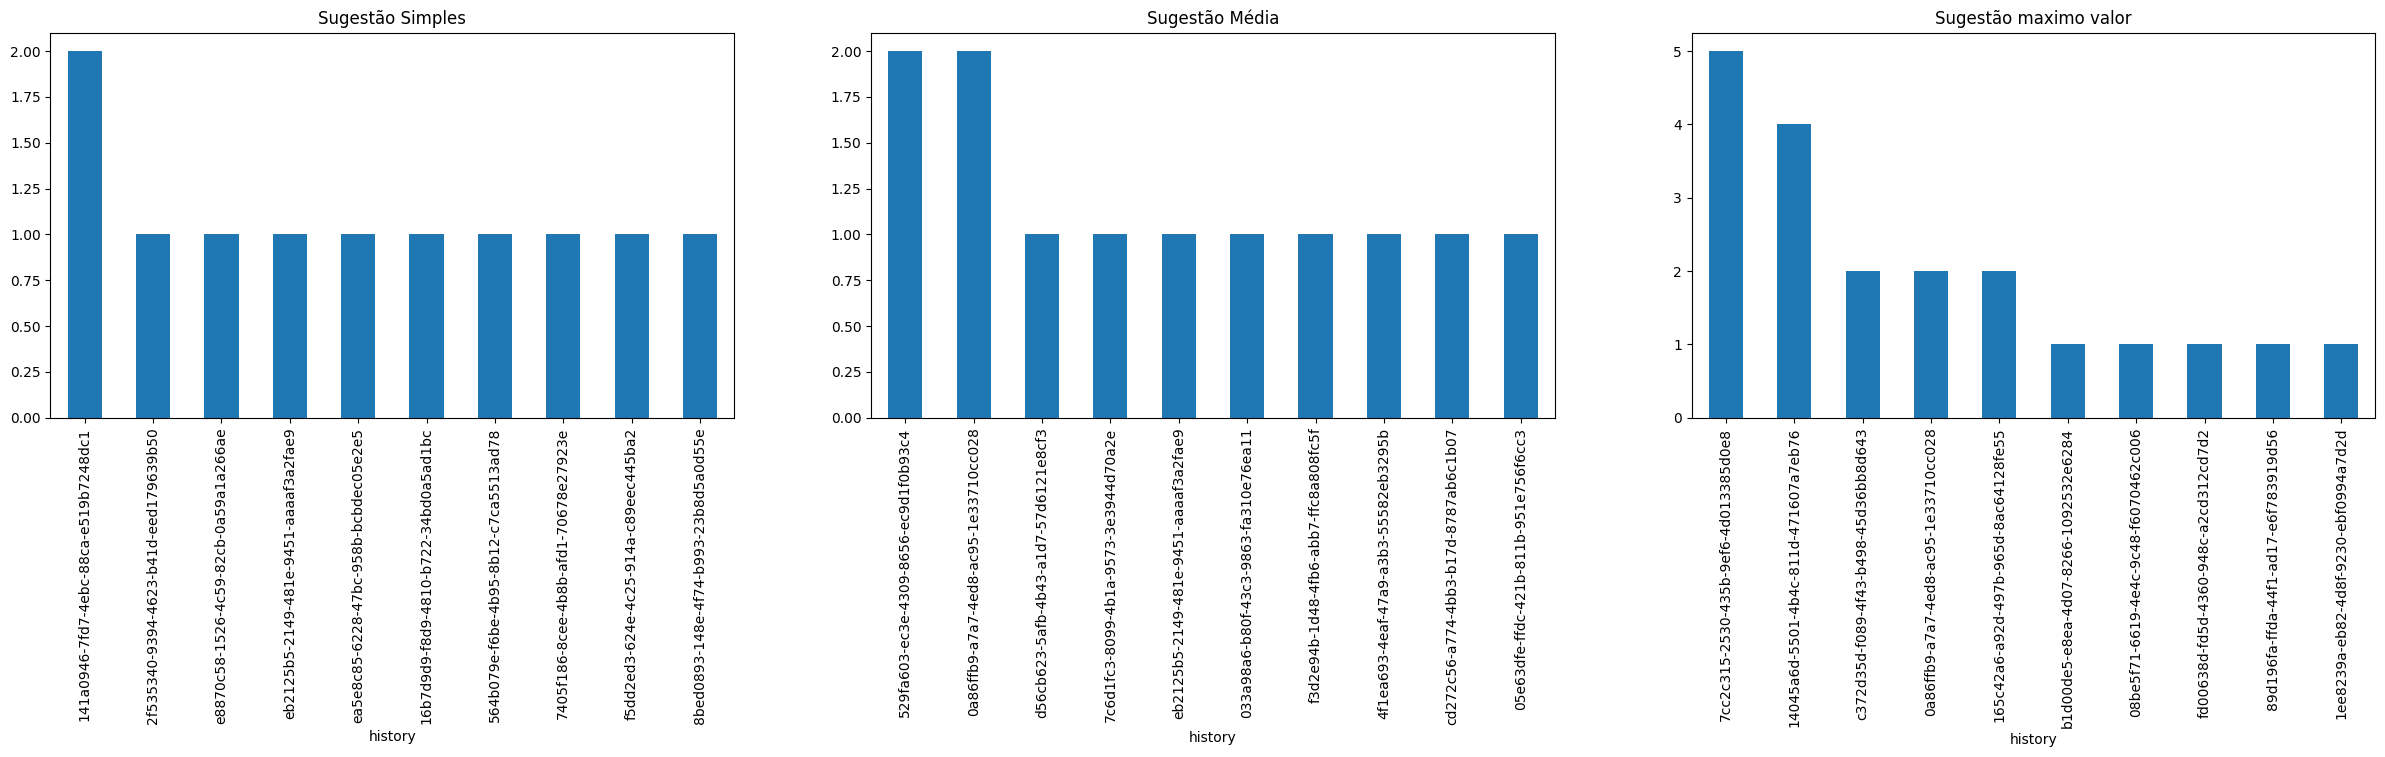

In [323]:
fix, axes = plt.subplots(1, 3, figsize=(30, 5))
axes = axes.flatten()

df_treino[df_treino['history'].isin(lista_susgestao_simples)]['history'].value_counts().plot(kind='bar', legend=None, ax=axes[0])
axes[0].set_title('Sugestão Simples')

df_treino[df_treino['history'].isin(lista_susgestao_media)]['history'].value_counts().plot(kind='bar', legend=None, ax=axes[1])
axes[1].set_title('Sugestão Média')

df_treino[df_treino['history'].isin(lista_susgestao_max)]['history'].value_counts().plot(kind='bar', legend=None, ax=axes[2])
axes[2].set_title('Sugestão maximo valor')

axes = axes

outras informações, como localização do leitor por exemplo, talvez ajudassem a gerar melhores recomendações, mas por hora vou aceitar o resultado que obtive nessa primeira analise.

#### Semelhanças entre matérias acessadas por um mesmo usuário

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [40]:
df_treino = pd.read_csv('./data/files/treino/long_format.csv')
df_itens = pd.read_csv('./data/itens/itens/long_format.csv')

In [3]:
df_treino.shape[0], df_itens.shape[0], df_treino['userId'].unique().shape[0]

(8123951, 255603, 577942)

In [154]:
df_treino = df_treino[df_treino['history'].isin(df_itens['page'])]
df_itens = df_itens[df_itens['page'].isin(df_treino['history'])]

In [5]:
df_treino.shape[0], df_itens.shape[0], df_treino['userId'].unique().shape[0]

(577942, 78664, 577942)

In [8]:
df_treino['userId'].value_counts().sort_values(ascending=False)[:5]

userId
5f5e17781fc2ec0ddcfb2e9356e61c5d3d4b0b3c8fabd20917feb9e807463856    1
4a6c9749763dcddd3d6ca7c2bb184be5f4b0b790194cb5bcf1592e10e3f5c366    1
f98d1132f60d46883ce49583257104d15ce723b3bbda2147c1e31ac76f0bf069    1
2c1080975e257ed630e26679edbe4d5c850c65f3e09f655798b0bba9b42f2110    1
0adffd7450d3b9840d8c6215f0569ad942e782fb19b805367b02b709b73f42a1    1
Name: count, dtype: int64

Estranhamente, temos apenas uma referência valida à uma matéria por usuário. Isso limita muito nossas opções para avaliação de similaridades entre os usuários.

In [5]:
df_temp = df_treino.groupby('userId').max()
df_temp = pd.DataFrame(
    {
        'historySize': np.log1p(df_temp['historySize']),
        'timestampHistory': np.log1p(df_temp['timestampHistory']),
        'numberOfClicksHistory': np.log1p(df_temp['numberOfClicksHistory']),
        'timeOnPageHistory': np.log1p(df_temp['timeOnPageHistory']),
        'scrollPercentageHistory': np.log1p(df_temp['scrollPercentageHistory']),
        'pageVisitsCountHistory': np.log1p(df_temp['pageVisitsCountHistory']),
    }
)

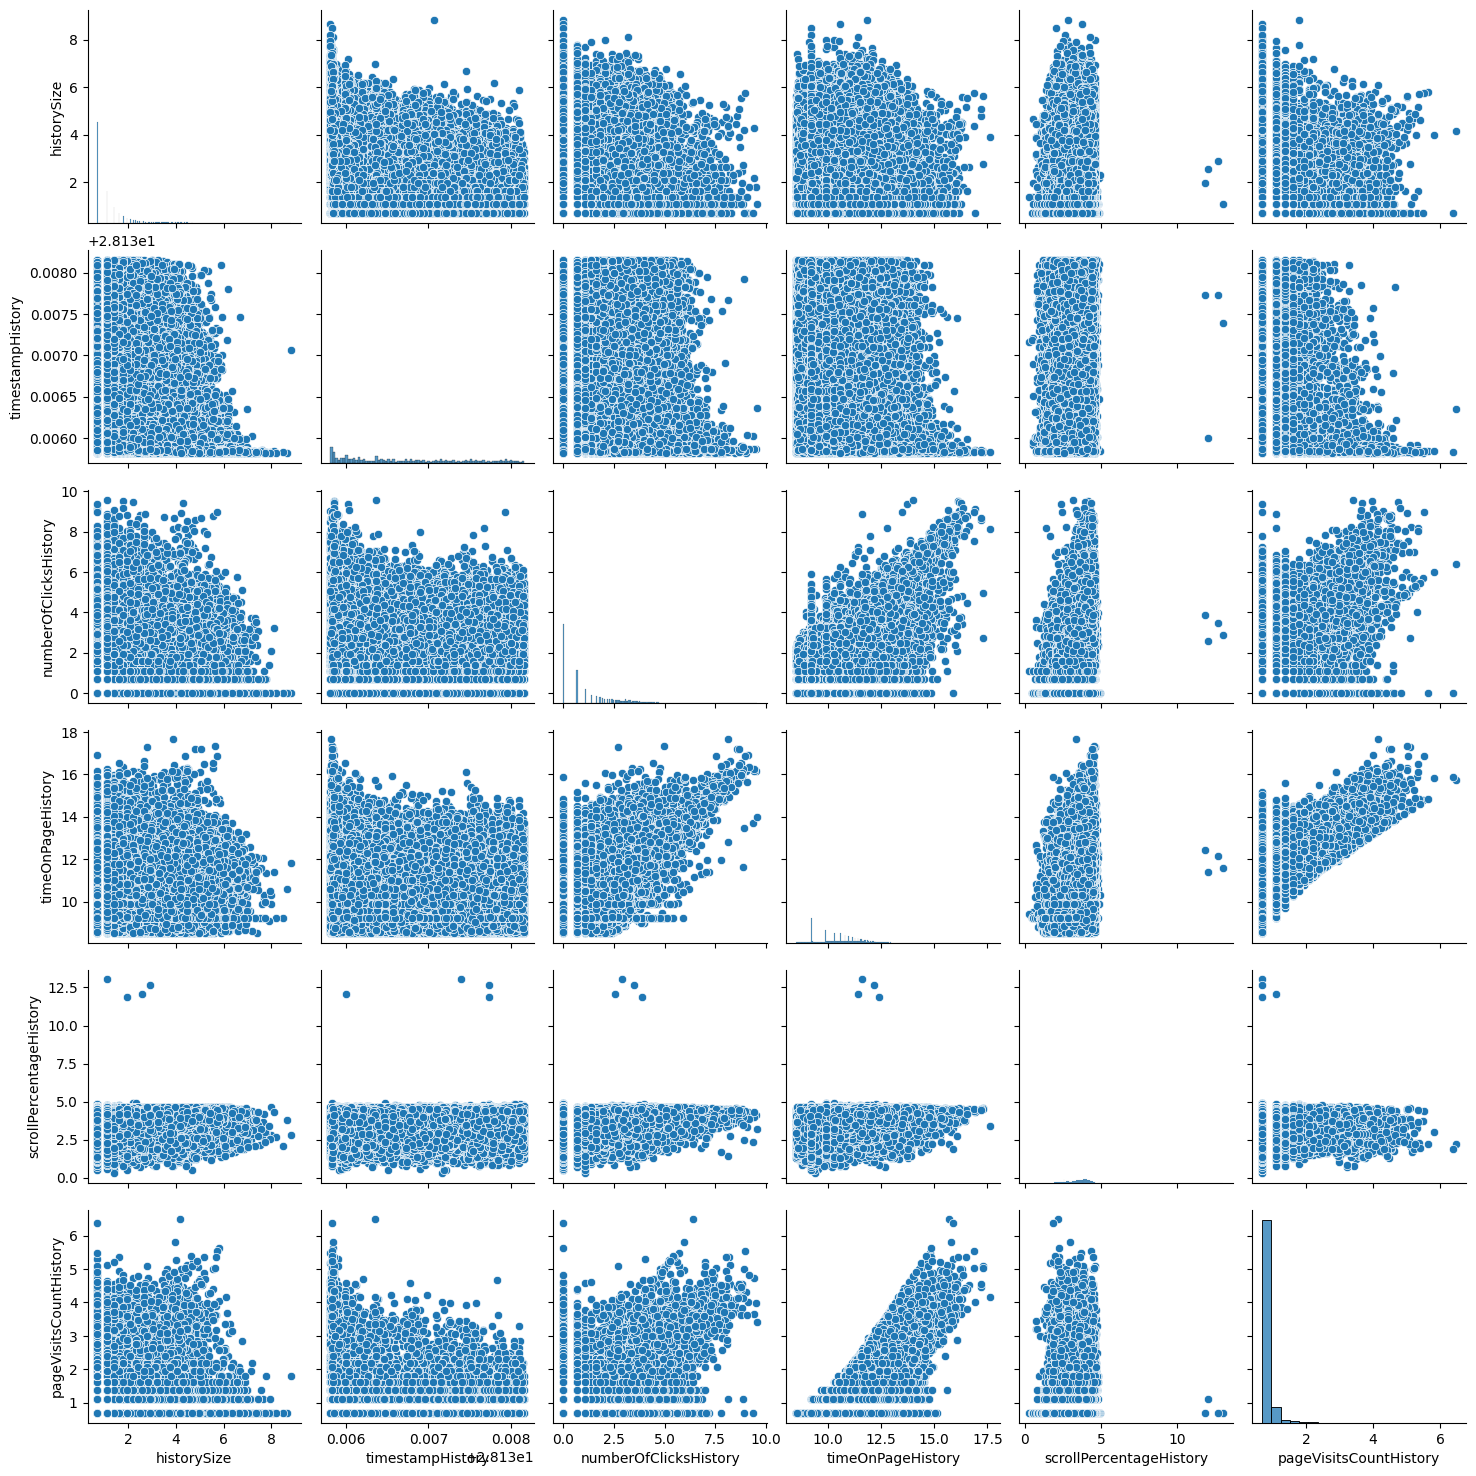

In [20]:
sns.pairplot(df_temp);

In [26]:
kmeans = KMeans(n_clusters=100)
previsao = kmeans.fit_predict(df_temp)
silhouette_score(df_temp, previsao)

np.float64(0.21361539464954202)

In [29]:
kmeans = KMeans(n_clusters=500)
previsao = kmeans.fit_predict(df_temp)
silhouette_score(df_temp, previsao)

np.float64(0.2225035911170341)

In [31]:
kmeans = KMeans(n_clusters=1000)
previsao = kmeans.fit_predict(df_temp)
silhouette_score(df_temp, previsao)

np.float64(0.2387741350944522)

In [32]:
kmeans = KMeans(n_clusters=10000)
previsao = kmeans.fit_predict(df_temp)
silhouette_score(df_temp, previsao)

np.float64(0.29012166151873486)

In [7]:
# Está demorando muito... infelizmente ou ter que usar amostragem no silhouette_score
kmeans = KMeans(n_clusters=50000)
previsao = kmeans.fit_predict(df_temp)
silhouette_score(df_temp, previsao, sample_size=int(len(df_temp) * 0.6), random_state=42)

np.float64(0.31614644855536445)

In [8]:
kmeans = KMeans(n_clusters=100000)
previsao = kmeans.fit_predict(df_temp)
silhouette_score(df_temp, previsao, sample_size=int(len(df_temp) * 0.6), random_state=42)

np.float64(0.32434474794302387)

In [14]:
def print_materias_por_grupo_usuarios(id_grupo: int):
    for ix, row in df_itens[df_itens['page'].isin(df_treino[previsao == id_grupo]['history'])].iterrows():
        print(row['title'])

In [15]:
print_materias_por_grupo_usuarios(1)

'Era para ser o dia mais feliz da minha vida', diz influencer do DF que teve casa invadida e furtada durante casamento
Nubank perde US$ 6 bi desde IPO e Itaú volta a ser banco mais valioso da América Latina; confira ranking
Imposto de Renda 2022: última correção da tabela foi em 2015; relembre
Para comemorar o aniversário de 70 anos, São Braz lança “Sabor de Prêmios da São Braz”
Empresário que estava internado após ser atingido por carro que invadiu restaurante morre em hospital de Goiânia
Enem 2021: professora da rede pública estadual do Ceará acerta tema da redação em exercício com alunos
Jason Alexander, ex-marido de Britney Spears, é acusado de perseguição após invadir casamento da cantora
Denúncia anônima levou policiais até apartamento onde influenciadora era agredida e mantida em cárcere privado
Número de brasileiros que vivem na pobreza quase triplicou em seis meses, diz FGV
Sobrinho de Pablo Escobar diz que encontrou sacola de dinheiro em parede de apartamento na Colômbia
Jove

In [17]:
print_materias_por_grupo_usuarios(2)

Violência psicológica foi a violação de direito mais sofrida por crianças e adolescentes, no DF
Confira os feriados e pontos facultativos decretados pelo governo de MS para 2022
Gabarito do Enem 2017 - 1º dia - prova branca
Eritritol x xilitol: conheça os adoçantes e prepare uma receita super-refrescante
A importância da atividade física durante a pandemia da covid-19
Alagoa se moderniza em busca de reconhecimento oficial como região produtora de queijo
Saião, flor de mamão, pata-de-vaca: os riscos dos tratamentos caseiros contra a diabetes
Hospitais e farmácias em todo o Brasil relatam falta de medicamentos, principalmente infantis
'Me bateram até ficar desacordado, iam me matar', diz jovem que foi agredido junto com a namorada pela PM em praça de MG
Pai da ex-BBB Amanda Gontijo morre em acidente de trânsito em Goiás
Sargentos da PM no AC assumem trisal e criam perfil para compartilhar rotina: 'somando as três vidas'


Como eu já estava esperando, a simples utilização dos dados de acesso dos usuários, sem a utilização de dados mas matérias acesssadas não produzindo bons resultados. Não é possóvel identificar padrões de conteúdo em matérias de um mesmo cluster.

Esse resultado é justificado, pois o conteúdo das matérias acessadas é mais relevante para identificar assuntos de interesse do que frequência e quantidade de acessos desse mesmo usuário. 2 usuários frequentes da plataforma podem ter interesses completamente diferentes.

O próximo passo inclui a utilização dos conteúdo das matérias para identificação dos interesses dos usuários, e possívelmente informações de engajamento para enriquecer os resultados.

In [168]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.pipeline import Pipeline

import pickle

In [139]:
with open('./models/vectorizer_body.pkl', 'rb') as file:
    vectorizer: TfidfVectorizer = pickle.load(file)

In [140]:
df_treino['userId'] = df_treino['userId'].astype('category')

usuario = df_treino.sample(1, random_state=42)['userId'].iloc[0]
usuario

'3af3dd1335a8bcd0a92d7ede0b077a28ec6edb2953494f3dff338bb7c156b9df'

In [155]:
atividade_usuario = df_treino[df_treino['userId'] == usuario]
materias_acesso_usuario = df_itens[df_itens['page'].isin(atividade_usuario['history'])]

In [156]:
X_usuario = vectorizer.transform(materias_acesso_usuario['body'])

In [157]:
datas = pd.to_datetime(df_itens['issued']).dt.tz_convert(None)
materias_recentes = df_itens[(datas >= datas.max() - pd.Timedelta(days=30)) & (~df_itens['page'].isin(materias_acesso_usuario['page']))]

In [158]:
X_materias_recentes = vectorizer.transform(materias_recentes['body'])

In [159]:
similaridades = cosine_similarity(X_usuario, X_materias_recentes)

In [160]:
print(df_itens.loc[df_itens['page'] == atividade_usuario.iloc[0]['history'], 'title'].iloc[0])
print('-----------------------------------------')

for _, row in materias_recentes.iloc[similaridades.max(axis=0).argsort()[-10:][::-1]].iterrows():
    print(row['title'])

Jovem é encontrado morto após ser filmado sendo colocado em viatura da PM; polícia investiga
-----------------------------------------
Vídeos mostram confusão envolvendo torcedores antes de jogo entre Coritiba e Santos, no estádio Couto Pereira
Polícia encontra corpo de jovem enterrado em aterro sanitário no interior de SP 
Mulher foge do marido e consegue denunciar que era agredida há anos, no Maranhão
Suspeito de matar mulher e filho bebê é transferido para SC
Suspeito de matar servidor municipal que defendeu namorada de estupro é indiciado por estupro, furto, roubo e latrocínio, diz polícia 
Homem é suspeito de matar irmão em briga durante jogo em Pontalina
Preso terceiro suspeito de matar casal a tiros em Barra Mansa
Mulher é apreendida com fuzil durante operação 'Sertão Seguro', em Arcoverde
PMs tentam furar blitz da Operação Lei Seca e são detidos em flagrante em Boa Viagem, no Recife
Casal é preso após se hospedar em hotel de Curvelo e sair sem pagar conta


Legal, já temos um bom começo buscando as matérias com conteúdo que se assemelha aos textos de matérias acessadas pelo usuário. Esses resultados já são bem interessantes, mas podemos incrementar ainda mais.

É possivel usar outros dados relacionados à atividade para incrementar esses resultados e dar mais peso à conteúdos mais relevantes para esse usuário. Por exemplo, faz mais sentido priorixar conteúdo mais recente, ou que se assemelha à materias que o usuário passou mais tempo visualizando.

In [161]:
# Fazendo uma cópia, assim posso testar algumas estratégias
temp = similaridades.copy()

Primeiramente quero usar a data de publicação das matérias para priorizar matérias mais recentes. Apesar de querer priorizar matérias mais recentes, também não quero que essa priorização tenha um peso muito grande no resultado final, para que o calculo de proximidade entre os textos não seja prejudicado

In [162]:
datas = pd.to_datetime(materias_recentes['issued']).dt.tz_convert(None)
datas = datas.astype('int64')
datas = np.array(datas - datas.min()) / (datas.max() - datas.min())
datas[:5]

array([0.46431403, 0.58023965, 0.31738776, 0.28507221, 0.42459904])

In [163]:
temp.shape, datas.shape

((1, 12963), (12963,))

In [164]:
temp = temp + (datas / 5) # DIVIDINDO O VALOR DAS DATAS PARA REDUZIR O PEDO DA DATA NO RESULTADO FINAL

In [165]:
print(df_itens.loc[df_itens['page'] == atividade_usuario.iloc[0]['history'], 'title'].iloc[0])
print('-----------------------------------------')

for _, row in materias_recentes.iloc[(temp + np.array(datas.astype(float).tolist()) / 5).max(axis=0).argsort()[-10:][::-1]].iterrows():
    print(row['title'])

Jovem é encontrado morto após ser filmado sendo colocado em viatura da PM; polícia investiga
-----------------------------------------
Preso terceiro suspeito de matar casal a tiros em Barra Mansa
Casal é preso após se hospedar em hotel de Curvelo e sair sem pagar conta
Vídeos mostram confusão envolvendo torcedores antes de jogo entre Coritiba e Santos, no estádio Couto Pereira

Menina de 12 anos relata a diretora beijo forçado a caminho de escola e suspeito é preso por estupro de vulnerável
PMs tentam furar blitz da Operação Lei Seca e são detidos em flagrante em Boa Viagem, no Recife
Mulher diz que foi agredida no primeiro encontro após dois meses de conversa por aplicativo
Mulher é apreendida com fuzil durante operação 'Sertão Seguro', em Arcoverde
Polícia deflagra operação em combate ao comércio de medicamentos veterinários falsos no Sul de Minas
Pastor de igreja é preso suspeito de estupro de vulnerável 
Carlinhos Maia: diamantes e relógio furtados do apartamento de influenciador 

Excelente, podemos ver que houveram algumas pequenas mudanças. Apesar de não muito grandes, priorizar matérias mais recentes ajuda a servir conteúdo novo, em vez de ter recomendações viciadas apresentando sempre os mesmos textos. 

Agora quero priorizar conteúdos que prenderam mais a atenção do uauário.

In [172]:
transformer = Pipeline([
    ('log1p', FunctionTransformer(np.log1p, validate=True)),
    ('minmax', MinMaxScaler())
])

In [173]:
transformer.fit(df_treino[['timeOnPageHistory', 'scrollPercentageHistory']]);

In [175]:
X = transformer.transform(atividade_usuario[['timeOnPageHistory', 'scrollPercentageHistory']])

In [176]:
np.mean(X, axis=1)

array([0.33994538])

In [178]:
temp = temp + np.mean(X, axis=1)

In [179]:
print(df_itens.loc[df_itens['page'] == atividade_usuario.iloc[0]['history'], 'title'].iloc[0])
print('-----------------------------------------')

for _, row in materias_recentes.iloc[(temp + np.array(datas.astype(float).tolist()) / 5).max(axis=0).argsort()[-10:][::-1]].iterrows():
    print(row['title'])

Jovem é encontrado morto após ser filmado sendo colocado em viatura da PM; polícia investiga
-----------------------------------------
Preso terceiro suspeito de matar casal a tiros em Barra Mansa
Casal é preso após se hospedar em hotel de Curvelo e sair sem pagar conta
Vídeos mostram confusão envolvendo torcedores antes de jogo entre Coritiba e Santos, no estádio Couto Pereira

Menina de 12 anos relata a diretora beijo forçado a caminho de escola e suspeito é preso por estupro de vulnerável
PMs tentam furar blitz da Operação Lei Seca e são detidos em flagrante em Boa Viagem, no Recife
Mulher diz que foi agredida no primeiro encontro após dois meses de conversa por aplicativo
Mulher é apreendida com fuzil durante operação 'Sertão Seguro', em Arcoverde
Polícia deflagra operação em combate ao comércio de medicamentos veterinários falsos no Sul de Minas
Pastor de igreja é preso suspeito de estupro de vulnerável 
Carlinhos Maia: diamantes e relógio furtados do apartamento de influenciador 

Agora temos como calcular a semelhança entre os textos lidos por um usuário, priorizar matérias mais recentes e dar um peso ainda maior à materias em que o usuário prestou mais atenção.

Com essa lógica implementada até agora eu tenho a impressão de que as recomendações estão bem consistentes. O próximo passo é a implementação dessa logíca de uma forma que possa ser reutilizada na aplicação.

# Resumo da análise

**O que nós temos até agora:**

*userType*: <br>
Existem 2 tipos de usuários, os uauários logados e não logados. Nós temos muita pouca informação entre os usuários, o que limita a nossa análise em termos de continuidade da navegação.<br>
A princípio eu não consigo imaginar muitas formas de utilizar essa informação no nosso sistema de recomendação. Seria interessante utilizar o tipo de usuário, se pudessemos conectar os dados de navegação de usuários não logados e logados para mapear melhor o perfil de cada utilizador, mas sendo essa correlação impossível de ser feita com os dados que possuímos, então vou considerar cada usuário como um indivíduo único.

*historySize*: <br>
Podemos usar essa informação para separar usuários frequestes de usuários esporádicos. Essa informação deve ajudar a explorar os diferentes perfis, e testar algumas premissas com relação aos interesses entre diferentes perfis.

*history*: <br>
Esse é o identificador da matéria que o usuário acessou. Nos permite conectar os dados de navegação do usuário à matérias específicas.

*timestampHistory*: <br>
Essa informação nos permite calcular quanto tempo, após a publicação de uma notícia, um usuário levou para acessá-la. Notícias com uma média de tempo de acesso mais baixo, tende a ser de maior interesso dos leitores.

*numberOfClicksHistory*: <br>
Parece ser a quantidade de cliques que o leitor deu no corpo da matéria. Ainda não sei como essa informação pode ser útil.

*timeOnPageHistory*: <br>
A contagem de tempo que um usuário ficou na matéria pode nos dar indícios que esse usuário esteve interessado no conteúdo apresentado. É esperado que usuários que permaneceram mais tempo em uma matéria possam ter interesse no assunto abordado, portanto é insumo para o sistema de recomendações.


*scrollPercentageHistory*: <br>
O porcentagem de rolagem da matéria possui a mesma caracteristica do *timeOnPageHistory*. Quanto maior a porcentagem de rolagem, maior o provável interesse do uauário no conteúdo da matéria.

*pageVisitsCountHistory*: <br>
Parece ser a quantidade de vezes que o usuário acessou a mesma página. Não sei ainda como essa informação pode ser útil.

*Popularidade*: <br>
A popularidade de uma matéria pode ser medida pela quantidade de acessos que ela teve, essa métrica nos ajuda a entender quais matérias possuem mais apelo popular. Espera-se que matérias com conteúdos semelhantes à matérias que tiveram grande numeros de acessos, tenham resultados semelhantes.

> Enquanto eu trabalhava na análise de popularidade das matérias eu percebi uma inconsistencia entre os dataframes de acessos e matérias. Temos dados de acessos para matérias que não estão presentes no dataframe de matérias e vice versa.

## Recomendações para cold start

Recomendações de cold start são utilizadas para sugerir conteúdo, quando o usuário ainda não possui um histórico de acessos que possa ser usádo como base para as recomendações.

O desafio do cold start é que ainda não conhecemos os gostos e interesses do leitor, por isso temos que nos basear no perfil de consumo de outros usuários para iniciar nossas recomendações.

Para esse projeto, a estratégia de cold start se resume em identificar as matérias com maior numero de acessos, e então buscar matérias semelhantes para usar como recomendação, um vez que espera-se que matérias que se assemelham com outras que já possuem um grande nível de interesse dos usuários possam replicar esse sucesso.

Também são favorecidas as matérias mais recentes. Esse favorecimento é feito para evitar que conteúdo muito antigo, e possívelmente não mais relevante, seja recomendado em vez de conteúdo mais recente.

## Recomendações para usuários conhecidos

Diferentemente do cold start, usuários conhecidos já possuem histórico de leitura que podemos utilizar para identificar o perfil e interesses do usuário. Para esses leitores podemos tentar mapear o perfil de conteúdo que ele acessa e sugerir mais matérias semelhantes.
 

# Logicas de recomendação

## Recomendação baseada em popularidade para cold start

Para recomendações de cold start, temos como objetivo encontrar as matérias mais populares do site, então procurar matérias semelhantes a essas matérias mais populates.

A premissa é que, se recomendarmos matérias semelhantes à matérias que já obtiveram um bom desempenho, nós podemos ter resultados muito próximos dos obtidos nas matérias mais populares. Por exemplo, se uma matéria falando sobre o desempenho da seleção brasileira na copa passada obteve 100 mil visualizações, podemos imaginar que matérias relacionadas à seleção brasileira na copa atual pode dispertar o mesmo interesse nos leitores.

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import pandas as pd
import numpy as np
import pickle
import os

In [2]:
def obtem_materias_populares(df_acessos: pd.DataFrame, df_materias: pd.DataFrame):
    # PRIMEIRAMENTE VAMOS CONFIRMAR QUE AMBOS DATAFRAMES ESTÂO CONSISTENTES ENTRE SI
    df_acessos = df_acessos[df_acessos['history'].isin(df_materias['page'])]
    df_materias = df_materias[df_materias['page'].isin(df_acessos['history'])]

    # AGORA QUERO LISTAR OS MAIORES ACESSOS
    acessos = df_acessos['history'].value_counts()

    # ENTÃO POSSO USAR O 99 PERCENTIL PARA FILTRAR AS MATÉRIAS MAIS ACESSADAS DE FORMA DINÂMICA
    acessos_minimo = np.percentile(acessos, 99)
    acessos = acessos[acessos >= acessos_minimo]

    return df_materias[df_materias['page'].isin(acessos.index)]

In [3]:
def cria_ou_atualiza_lista_materias_populates(df_acessos:pd.DataFrame, df_materias:pd.DataFrame):
    materias_populares = obtem_materias_populares(df_acessos, df_materias)
    materias_populares.to_csv('./models/data/materias_populares.csv', index=False)
    return materias_populares

In [4]:
def obtem_materia_recentes(df_materias: pd.DataFrame, dias: int):
    return df_materias[df_materias['issued'] >= df_materias['issued'].max() - pd.Timedelta(days=dias)]

In [5]:
def carregar_vectorizer() -> TfidfVectorizer:
    with open(r'models/vectorizer_body.pkl', 'rb') as file:
        return pickle.load(file)

In [6]:
def cria_ou_atualiza_list_cold_start(dias=14, quantidade_itens=10):
    os.makedirs('./models/data', exist_ok=True)

    df_acessos = pd.read_csv('./data/files/treino/long_format.csv')
    df_materias = pd.read_csv('./data/itens/itens/long_format.csv')

    df_materias['issued'] = pd.to_datetime(df_materias['issued']).dt.tz_convert(None)

    vectorizer = carregar_vectorizer()

    materias_populares = cria_ou_atualiza_lista_materias_populates(df_acessos, df_materias)
    materias_recentes = obtem_materia_recentes(df_materias, dias)

    vec_materias_populares = vectorizer.transform(materias_populares['body'])
    vec_materias_recentes = vectorizer.transform(materias_recentes['body'])

    similaridades = cosine_similarity(vec_materias_populares, vec_materias_recentes)
    mais_parecidas_ix = similaridades.max(axis=1).argsort()[-quantidade_itens:]
    df_mais_parecidas = df_materias.iloc[mais_parecidas_ix]

    df_mais_parecidas.to_csv('./models/data/cold_start.csv', index=False)
    
    return df_mais_parecidas
    

In [7]:
cria_ou_atualiza_list_cold_start()

,page,url,issued,modified,title,body,caption
577,b559f4bf-099c-452a-9288-6146829df03f,http://g1.globo.com/sp/mogi-das-cruzes-suzano/...,2022-08-04 13:13:32,2022-08-04 13:13:33+00:00,Número de veículos convertidos para GNV no Alt...,Veículo convertido para GNV.\nMiriane Pinheiro...,"Aumento de conversões foi de 92,79% na compara..."
777,e5ce7fe5-287d-4ebe-9f70-e70b764eaa1d,http://g1.globo.com/fantastico/noticia/2022/01...,2022-01-17 01:30:27,2022-01-17 01:30:35+00:00,"Conheça o ateliê de 'Pigcasso', a porquinha pi...","Conheça o ateliê de 'Pigcasso', a porquinha pi...",A porquinha da África do Sul tem feito sucesso...
625,ad543dfb-2ddd-4878-9f6a-83fbefbdd826,http://g1.globo.com/sp/sao-jose-do-rio-preto-a...,2021-08-13 10:09:33,2021-08-13 20:39:31+00:00,Pai filma e posta vídeo agredindo filho de 8 a...,Pai filma e posta agressão contra filho de 8 a...,"Caso aconteceu em Birigui, interior de São Pau..."
645,ff25cb7a-fd4f-4ce9-b67b-99b8aa44ca0e,http://g1.globo.com/mundo/noticia/2021/07/25/i...,2021-07-25 19:12:08,2021-07-25 19:26:37+00:00,Influencer de 23 anos morre após cair de guind...,Influencer chinesa tinha 23 anos e caiu do gui...,"Ela era uma estrela do Douyin, a versão chines..."
156,fc5fd150-bf66-4b9e-94d4-55083c78de67,http://g1.globo.com/go/goias/noticia/2022/06/2...,2022-06-29 22:57:01,2022-06-30 00:06:05+00:00,Filhas agradecem pela prisão de jovem filmado ...,"Montagem reúne Felipe Gabriel, preso suspeito ...","Kênnia Bianka, que presenciou a morte do pai, ..."
283,8d178071-0640-4580-9d46-e4a468c5402e,http://g1.globo.com/pa/para/noticia/2022/07/01...,2022-07-01 21:34:47,2022-07-01 21:34:47+00:00,MPF cobra medidas para proteção de agricultore...,O Ministério Público Federal (MPF) cobrou medi...,Anúncio da cobrança foi feito nesta sexta-feir...
514,604a392a-e35e-46a7-a158-75ac1f00397f,http://g1.globo.com/sp/sao-paulo/noticia/2021/...,2021-07-23 12:46:31,2021-07-23 17:31:58+00:00,'Ela se envolveu com pessoas erradas. Família ...,VÍDEO: Irmão da 'gatinha da Cracolândia' diz q...,"Lorraine Bauer Romeiro, de 19 anos, foi presa ..."
695,f9b7355c-e740-4ee7-b9b6-d96807ff4e7e,http://g1.globo.com/economia/noticia/2022/05/2...,2022-05-26 10:22:32,2022-05-26 15:50:07+00:00,O retrato da disparada da inflação no 'prato f...,O retrato da disparada da inflação no 'prato f...,Preços de três alimentos no prato dos brasilei...
92,c64e846b-c86d-4b8e-ac2a-f2cd0b7392ee,http://g1.globo.com/ba/bahia/saojoao2022/notic...,2022-05-31 21:16:19,2022-06-02 13:29:28+00:00,Governo da Bahia anuncia esquema especial de S...,Governo da Bahia anuncia esquema especial de S...,Reunião com representantes da SSP e da Bahiatu...
753,0457722f-8d4c-4da4-bfce-b1a9f41aab8f,http://g1.globo.com/pop-arte/noticia/2021/05/2...,2021-05-20 15:46:54,2021-05-20 15:46:54+00:00,Sebastião Salgado lança mostra 'Amazônia' em P...,Sebastião Salgado\nJOEL SAGET / AFP\nCelebrar ...,Exposição ainda vai viajar por cidades como Lo...


In [8]:
def obtem_recomendacoes_cold_start():
    cold_start = pd.read_csv('./models/data/cold_start.csv')
    return cold_start[['url', 'title']]

In [9]:
obtem_recomendacoes_cold_start()

,url,title
0,http://g1.globo.com/sp/mogi-das-cruzes-suzano/...,Número de veículos convertidos para GNV no Alt...
1,http://g1.globo.com/fantastico/noticia/2022/01...,"Conheça o ateliê de 'Pigcasso', a porquinha pi..."
2,http://g1.globo.com/sp/sao-jose-do-rio-preto-a...,Pai filma e posta vídeo agredindo filho de 8 a...
3,http://g1.globo.com/mundo/noticia/2021/07/25/i...,Influencer de 23 anos morre após cair de guind...
4,http://g1.globo.com/go/goias/noticia/2022/06/2...,Filhas agradecem pela prisão de jovem filmado ...
5,http://g1.globo.com/pa/para/noticia/2022/07/01...,MPF cobra medidas para proteção de agricultore...
6,http://g1.globo.com/sp/sao-paulo/noticia/2021/...,'Ela se envolveu com pessoas erradas. Família ...
7,http://g1.globo.com/economia/noticia/2022/05/2...,O retrato da disparada da inflação no 'prato f...
8,http://g1.globo.com/ba/bahia/saojoao2022/notic...,Governo da Bahia anuncia esquema especial de S...
9,http://g1.globo.com/pop-arte/noticia/2021/05/2...,Sebastião Salgado lança mostra 'Amazônia' em P...


## Recomendações baseadas em atividade de usuário

Diferente do cold start, as recomendações baseadas em atividades de usuário são aquela que utilizam informações históricas desse usuário para gerar recomendações parecidas.

Nesses casos buscamos priorizar conteúdo que possua alguma semelhança com outros conteúdos que esse mesmo usuário tenha demonstrado interesse prévio.

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.pipeline import Pipeline

import numpy as np

In [7]:
def obter_atividade_usuario(df_acessos:pd.DataFrame, df_materias:pd.DataFrame, id_usuario:str):
    return df_acessos.loc[(df_acessos['userId'] == id_usuario) & (df_acessos['history'].isin(df_materias['page']))]

In [8]:
def obter_materias_acessadas(df_acessos:pd.DataFrame, df_materias:pd.DataFrame):
    return df_materias.loc[df_materias['page'].isin(df_acessos['history'])]

In [10]:
def obter_matriz_similaridades(materias_acessadas:pd.DataFrame, materias:pd.DataFrame):
    vectorizer = carregar_vectorizer()
    X_acessadas = vectorizer.transform(materias_acessadas['body'])
    X_materias = vectorizer.transform(materias['body'])
    return np.array(cosine_similarity(X_acessadas, X_materias))

In [27]:
def obtem_pesos_por_data_publicacao(materias:pd.DataFrame):
    datas = materias['issued'].astype('int64')
    datas = (datas - datas.min()) / (datas.max() - datas.min())
    return np.array(datas / 5)

In [11]:
def cria_pipeline_transformacao():
    return Pipeline([
        ('log1p', FunctionTransformer(np.log1p, validate=True)),
        ('minmax', MinMaxScaler())
    ])

In [13]:
def criar_ou_carregar_transformador(df_acessos:pd.DataFrame):
    if os.path.exists('./models/transformer.pkl'):
        with open('./models/transformer.pkl', 'rb') as file:
            return pickle.load(file)
    else:
        transformer = cria_pipeline_transformacao()
        transformer.fit(df_acessos[['timeOnPageHistory', 'scrollPercentageHistory']])
        with open('./models/data/transformer.pkl', 'wb') as file:
            pickle.dump(transformer, file)
        return transformer

In [14]:
def obtem_pesos_por_atividade_usuario(atividade_usuario:pd.DataFrame, transformer:Pipeline):
    X = transformer.transform(atividade_usuario[['timeOnPageHistory', 'scrollPercentageHistory']])
    return np.mean(X, axis=1)

In [16]:
def transforma_acessos_usuario(df_acessos:pd.DataFrame, atividade_usuario:pd.DataFrame):
    transformer = criar_ou_carregar_transformador(df_acessos)
    return obtem_pesos_por_atividade_usuario(atividade_usuario, transformer)

In [22]:
def obtem_recomendacoes_usuario(id_usuario:str, itens=10):
    df_acessos = pd.read_csv('./data/files/treino/long_format.csv')
    df_materias = pd.read_csv('./data/itens/itens/long_format.csv')

    df_materias['issued'] = pd.to_datetime(df_materias['issued']).dt.tz_convert(None)

    materias_recentes = obtem_materia_recentes(df_materias, 30)
    atividade_usuario = obter_atividade_usuario(df_acessos, df_materias, id_usuario)
    materias_acessadas = obter_materias_acessadas(atividade_usuario, df_materias)

    similaridades = obter_matriz_similaridades(materias_acessadas, materias_recentes)
    pesos_data_publicacao = obtem_pesos_por_data_publicacao(materias_recentes)
    pesos_atividade_usuario = transforma_acessos_usuario(df_acessos, atividade_usuario)

    similaridades = similaridades + pesos_data_publicacao + pesos_atividade_usuario

    return materias_recentes.iloc[similaridades.max(axis=0).argsort()[-itens:][::-1]]

In [25]:
id_usuario = pd.read_csv('./data/files/treino/long_format.csv')['userId'].sample(1, random_state=42).iloc[0]
id_usuario

'3af3dd1335a8bcd0a92d7ede0b077a28ec6edb2953494f3dff338bb7c156b9df'

In [31]:
recomendacoes = obtem_recomendacoes_usuario(id_usuario)

In [32]:
for ix, row in recomendacoes.iterrows():
    print(row['title'])

Jovem é encontrado morto após ser filmado sendo colocado em viatura da PM; polícia investiga
Vídeos mostram confusão envolvendo torcedores antes de jogo entre Coritiba e Santos, no estádio Couto Pereira
Preso terceiro suspeito de matar casal a tiros em Barra Mansa
Casal é preso após se hospedar em hotel de Curvelo e sair sem pagar conta
Mulher é apreendida com fuzil durante operação 'Sertão Seguro', em Arcoverde
PMs tentam furar blitz da Operação Lei Seca e são detidos em flagrante em Boa Viagem, no Recife

Menina de 12 anos relata a diretora beijo forçado a caminho de escola e suspeito é preso por estupro de vulnerável
Polícia deflagra operação em combate ao comércio de medicamentos veterinários falsos no Sul de Minas
Pastor de igreja é preso suspeito de estupro de vulnerável 
Jovem é preso suspeito de espancar servente de pedreiro após ele denunciá-lo por tráfico de drogas, em Catalão


O código para gerar a as recomendações baseadas em atividade de usuário serve como base para implementação da API. Agora temos todos os passos para gerar as recomendações necessárias.

A mesma lógica para gerar recomendações baseadas na atividade de usuário podem ser extendidas para busca e pode ajudar a trazer as matérias mais relevantes no topo.

# Criando o banco de dados para utilização pela API.

O objetivo do código a seguir é converter os dados que até o momento estão em formato CSV para um banco de dados que possa ser utilizado pela API de recomendações.

In [11]:
from sqlalchemy import create_engine, Column, ForeignKey, String, DateTime, Integer
from sqlalchemy.orm import Session, DeclarativeBase, mapped_column, relationship

import pandas as pd

import uuid

In [ ]:
engine = create_engine('sqlite:///./database.db')

In [8]:
class Base(DeclarativeBase):
    pass

class Materia(Base):
    __tablename__ = 'materias'

    id = Column(String, primary_key=True, default=lambda: str(uuid.uuid4()))
    titulo = Column(String, nullable=False)
    descricao = Column(String, nullable=False)
    conteudo = Column(String, nullable=False)
    publicado = Column(DateTime, nullable=False)

    atividades = relationship("Atividade", back_populates="materia", cascade="all, delete-orphan")


class Atividade(Base):
    __tablename__ = 'atividades'

    id = Column(Integer, primary_key=True, autoincrement=True)
    usuario = Column(String, nullable=False)
    materia_id = Column(String, ForeignKey('materias.id'), nullable=False)
    tempo_leitura = Column(Integer, nullable=False)
    porcentagem_scroll = Column(Integer, nullable=False)

    materia = relationship("Materia", back_populates="atividades")

Base.metadata.create_all(engine)

In [12]:
df_materias = pd.read_csv('./data/itens/itens/long_format.csv')
df_materias['issued'] = pd.to_datetime(df_materias['issued']).dt.tz_convert(None)

lista_materias = [ 
    Materia(id=row['page'], titulo=row['title'], descricao=row['caption'], conteudo=row['body'], publicado=row['issued']) 
    for _, row in df_materias.iterrows() 
]

with Session(engine) as session:
    session.add_all(lista_materias)
    session.commit()

In [13]:
df_acessos = pd.read_csv('./data/files/treino/long_format.csv')
df_acessos = df_acessos[df_acessos['history'].isin(df_materias['page'])]

lista_acessos = [
    Atividade(usuario=row['userId'], materia_id=row['history'], tempo_leitura=row['timeOnPageHistory'], porcentagem_scroll=row['scrollPercentageHistory'])
    for _,row in df_acessos.iterrows()
]

with Session(engine) as session:
    session.add_all(lista_acessos)
    session.commit()

agora também temos um banco de dados para ser usado pela nossa API.

Após essa ultima implementação estamos finalmente prontos para a implementação da API